**OpenBlas may create problems, see below before starting jupyter session**

In [12]:
#!!!! May need to curb OpenBlas threads !!!! (Only once per session)
#export OMP_NUM_THREADS=1 (run directly in command line, not from jupyter notebook)

# Markov chains for length bias quantification in scRNA-seq: a Colab demonstration

In this notebook, we illustrate a Markov chain approach for joint probabilistic description of technical and biological noise in scRNA-seq.

We implement a [conventional two-stage model](https://www.sciencedirect.com/science/article/pii/S0006349512007904?via%3Dihub) for the living cell dynamics. Unspliced mRNA transcripts are produced in geometric bursts. These unspliced transcripts are spliced, then degraded. After equilibration, the sequencing process starts, halting all biological processes. The cDNA library construction is a pure-birth process: it yields $Poisson(\lambda_u)$ *in silico* UMIs for each unspliced mRNA and $Poisson(\lambda_s)$ UMIs for each spliced mRNA.

We use a length-dependent model of UMI capture. Specifically, we posit that $\lambda_u = C_u L$, where $L$ is the length of the full gene: longer genes have more poly(A) stretches that can be captured by the oligo(dT) primers used in scRNA-seq. On the other hand, $\lambda_s$ is presumed constant across all genes: spliced transcripts are primarily captured at the poly(A) tail appended before nuclear export.

We scan over a grid of $\{C_u, \lambda_s\}$ values, compute the conditional maximum likelihood estimates for the biological parameters, identify a sampling parameter optimum, and investigate parameter trends and fit quality. 

In [1]:
from datetime import date
import time
t1 = time.time()

## Prerequisites

First, install the necessary numerical differentiation, parallelization, and `loom` file import packages.

In [ ]:
# !pip -q install numdifftools 
# !pip -q install parfor
# !pip -q install loompy

     |████████████████████████████████| 99 kB 4.3 MB/s 
     |████████████████████████████████| 189 kB 38.7 MB/s 
     |████████████████████████████████| 41 kB 123 kB/s 
     |████████████████████████████████| 48 kB 4.6 MB/s 


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
import warnings
warnings.filterwarnings("ignore")

Clone the project GitHub repository to collect the data and processing scripts. The [10X](https://figshare.com/articles/dataset/10X_protein_and_mRNA_counts/9912734/1?file=17820449) dataset was processed using `kb` for the [protein velocity article](https://genomebiology.biomedcentral.com/articles/10.1186/s13059-020-1945-3), collected from Figshare, and uploaded to Github.

In [4]:
!git clone https://github.com/tarachari3/GP_2021_3.git
#https://github.com/tarachari3/GP_2021_3.git
#https://github.com/gennadygorin/seq-cme-technoise

Cloning into 'GP_2021_3'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (99/99), done.s: 100% (99/99)
remote: Compressing objects: 100% (61/61), done.
remote: Total 298 (delta 56), reused 69 (delta 37), pack-reused 199
Receiving objects: 100% (298/298), 53.31 MiB | 30.43 MiB/s, done.
Resolving deltas: 100% (120/120), done.


In [5]:
!mv GP_2021_3/* .

#!mv seq-cme-technoise/* .

#!rm -r seq-cme-technoise

In [6]:
!mv polyA_ref/* .

In [4]:
# Can add this function later to seq_cme_inference
# Write input txt file

def genRunInput(fname='example_input.txt',dataDir = './',outDir='./',loomName = '',tranName = '',polyaA='15',tInd='0',
                filt='0.01, 0.01, 350, 350, 3, 3',exclude='',attList="[['spliced','unspliced','Gene','Barcode']]",
                seed='42', nGenes='5000', ind='0', gList='', lb='-2, -1.8, -1.8', ub='4.2, 2.5, 2.5',
                restart='1',init='moments',length='True',niter='20',nCu='10',nlambda='11',
                lbSamp='-9, -4',ubSamp='-4, 1.5',suffix='1',creator='tc',ncor='20',override=''):
    '''
    Generate run file for CME inference procedure. 
    Parameters listed in order of appearance in run text file.
    For a dry-run set ind = '-1'.

    Parameters:
    fname: filepath for run file
    dataDir: filepath for data directory
    outDir: filepath for output directory
    loomName: loom filenames
    tranName: transcriptome filepath
    polyaA: min polyA count
    tInd: column of transcriptome file (lengths if 0, polyA count if 1)
    filt: min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
    exclude:  result files (with genes to exclude)
    attList: list of lists for loom attribute names
    seed: gene selection seed
    nGenes: number of genes to select
    ind: loom file to analyze
    gList: result files to use for gene names
    lb: log10 of lower bound on burst size, splice rate, degradation rate
    ub: upper bound on on burst size, splice rate, degradation rate
    restart: how many times to run the search for each gene
    init: method to start search; 'random' if nothing
    length: use gene length for Poisson sampling
    niter: max iterations of gradient descent
    nCu: number of C_u points to evaluate
    nlambda: number of lambda_s points to evalute
    lbSamp: lower limits of C_u and lambda_s
    ubSamp: upper limits of C_u and lambda_s
    suffix: folder directory suffix
    creator: directory creator name
    ncor: number of cores to use
    override: if empty, use today's date from computer, else use string provided

    Returns:
    Run file (txt)
    '''

    with open(fname, 'w') as f:
        f.write('#Parameter input for CME inference ')
        f.write('\n')
        f.write('dataset_directory : '+dataDir+' : folder with dataset loom files')
        f.write('\n')
        f.write('result_directory : '+outDir+' : where to put the result folder')
        f.write('\n')
        f.write('loom_filenames : '+loomName+' : filenames to integrate')
        f.write('\n')
        f.write('transcriptome_filename : '+tranName+' : transcriptome location')
        f.write('\n')
        f.write('polyA_threshold : '+polyaA+' : minimum polyA count to use for sampling function')
        f.write('\n')
        f.write('transcriptome_ind : '+tInd+' : column of transcriptome file to use (lengths if 0, polyA count if 1)')
        f.write('\n')
        f.write('filter_param : '+filt+' : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S')
        f.write('\n')
        f.write('all_prev_results : '+exclude+': result files with gene names to exclude')
        f.write('\n')
        f.write('attribute_names : '+attList+' : list or list of lists with loom attribute names')
        f.write('\n')
        f.write('gene_sel_seed : '+seed+' : gene selection seed')
        f.write('\n')
        f.write('n_gen : '+nGenes+' : number of genes to select')
        f.write('\n')
        f.write('IND : '+ind+' : loom_filename to analyze')
        f.write('\n')
        f.write('gene_list : '+gList+' : set of result files to import to define gene names')
        f.write('\n')
        f.write('phys_lb : '+lb+' : log10 of lower bound on burst size, splice rate, degradation rate')
        f.write('\n')
        f.write('phys_ub : '+ub+' : upper bound on same')
        f.write('\n')
        f.write('search_restarts : '+restart+' : how many times to run the search for each gene')
        f.write('\n')
        f.write("init_pattern : "+init+" : whether to start the search using method of moments estimate or not; 'random' if not")
        f.write('\n')
        f.write('use_lengths : '+length+' : whether the Poisson sampling for unspliced mRNA should depend on gene length')
        f.write('\n')
        f.write('maxiter : '+niter+' : number of iterations of gradient descent to perform')
        f.write('\n')
        f.write('n_pt1 : '+nCu+' : number of C_u points to evaluate')
        f.write('\n')
        f.write('n_pt2 : '+nlambda+' : number of lambda_s points to evalute')
        f.write('\n')
        f.write('samp_lb : '+lbSamp+' : lower limits of C_u and lambda_s')
        f.write('\n')
        f.write('samp_ub : '+ubSamp+' : upper limits of C_u and lambda_s')
        f.write('\n')
        f.write('ID_suffix : '+suffix+' : folder directory suffix')
        f.write('\n')
        f.write('creator : '+creator+' : directory creator name, can also be used for generic metadata')
        f.write('\n')
        f.write('NCOR : '+ncor+' : number of cores to use')
        f.write('\n')
        f.write("date_override : "+override+": if empty, use today's date from computer. if not, use the given string")




## Inference

Import the processing scripts.

In [5]:
from seq_cme_inference import *
from driver import *
from itertools import combinations
from matplotlib.colors import ListedColormap
import glob
import numpy as np
import pandas as pd

The implementation has a driver function. The driver is intended to be run from the command line, and pointed to an input script that defines the search parameters. If the driver is run in notebook, it outputs figures with gene count summaries.

The driver inputs a text file with parameters. The most salient ones are:


* `loom_filenames`: which `loom` files to fit? If multiple dataset names are listed, the process collects genes that are retained after filtering in *all* datasets. The specific file to analyze is indicated by the zero-indexed entry `IND`.
* `phys_lb` and `phys_ub`: what are the lower and upper bounds on $\log_{10}$ of the physical parameters $b$, $\beta$, and $\gamma$ = burst size, splicing rate, and degradation rate? Note that the rates are normalized to burst frequency $k_i$.
* `samp_lb` and `samp_ub`: what are the lower and upper bounds on $\log_{10}$ of the sampling parameters $C_u$ and $\lambda_s$? These parameters are scanned on a grid of dimensions `n_pt1`$\times$`n_pt2`.


In [9]:
#Make script in future to make these automatically (from user input)
#For dry-run set loom file index (IND) to -1

genRunInput() # Generate example_input.txt 
!cat example_input.txt 

#Parameter input for CME inference 
dataset_directory : ./ : folder with dataset loom files
result_directory : ./ : where to put the result folder
loom_filenames :  : filenames to integrate
transcriptome_filename :  : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 350, 350, 3, 3 : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','Gene','Barcode']] : list or list of lists with loom attribute names
gene_sel_seed : 42 : gene selection seed
n_gen : 5000 : number of genes to select
IND : 0 : loom_filename to analyze
gene_list :  : set of result files to import to define gene names
phys_lb : -2, -1.8, -1.8 : log10 of lower bound on burst size, splice rate, degradation rate
phys_ub : 4

Run the inference workflow. This will input the `loom` file, select genes with moderate expression (dark gray in second figure), and select a subset of those to fit (blue in second figure).

Each run creates a directory with the date and metadata (dataset name, grid size, number of genes). Some metadata can be defined in the input text file. The grid scan runs in parallel. The procedure is stable for searches with a lot of genes and grid points: if the algorithm halts, the intermediate results are stored.

The directory contains files for each grid point, a `metadata` file that defines the search parameters, a `nosamp` file with results for the noise-free fit, and a `result` file that bundles all results together and can be imported for further analysis.

### **Get all loom examples for QC analysis**

In [5]:
import loompy as lp


In [6]:
paths = ['/home/tchari/counts/clytia_stim/loom/clytia_SWall.loom',
        '/home/tchari/counts/clytia_stim/loom/clytiaNematocyte.loom',
        '/home/tchari/counts/gehring_nsc/loom/nsc45.loom',
        '/home/tchari/counts/replogle_crispr/loom/crisprsgNegCtrl02093a_sgNegCtrl3b.loom',
        '/home/tchari/gg_looms/pbmcs_10x.loom',
        '/home/tchari/gg_looms/neurons_10k.loom',
        '/home/tchari/gg_looms/desai_dmso.loom',
        '/home/tchari/counts/hagai_lps/24754_6/counts_filtered/adata_24754_6.loom']

#jellyfish, jellyfish, mouse, human,human,mouse,mouse

In [7]:
s_mats = []
u_mats = []
for i in paths:
    ds = lp.connect(i)
    s_mats += [ds.layers['spliced'].sparse()]
    u_mats += [ds.layers['unspliced'].sparse()]
    ds.close()
    


In [8]:
for i in range(len(u_mats)):
    print(paths[i] +": "+ str(u_mats[i].todense().T.shape[0])+" cells")

/home/tchari/counts/clytia_stim/loom/clytia_SWall.loom: 5251 cells
/home/tchari/counts/clytia_stim/loom/clytiaNematocyte.loom: 1256 cells
/home/tchari/counts/gehring_nsc/loom/nsc45.loom: 3632 cells
/home/tchari/counts/replogle_crispr/loom/crisprsgNegCtrl02093a_sgNegCtrl3b.loom: 1465 cells
/home/tchari/gg_looms/pbmcs_10x.loom: 11756 cells
/home/tchari/gg_looms/neurons_10k.loom: 11954 cells
/home/tchari/gg_looms/desai_dmso.loom: 904 cells
/home/tchari/counts/hagai_lps/24754_6/counts_filtered/adata_24754_6.loom: 3745 cells


In [9]:
for i in range(len(u_mats)):
    print(paths[i] +": \n"+ str(np.sum(s_mats[i]))+" S UMIs for " + str(u_mats[i].todense().T.shape[1])+ " genes")

/home/tchari/counts/clytia_stim/loom/clytia_SWall.loom: 
22854033.0 S UMIs for 40960 genes
/home/tchari/counts/clytia_stim/loom/clytiaNematocyte.loom: 
7008720.0 S UMIs for 45872 genes
/home/tchari/counts/gehring_nsc/loom/nsc45.loom: 
17328035.0 S UMIs for 32285 genes
/home/tchari/counts/replogle_crispr/loom/crisprsgNegCtrl02093a_sgNegCtrl3b.loom: 
13867522.0 S UMIs for 36601 genes
/home/tchari/gg_looms/pbmcs_10x.loom: 
72379650.0 S UMIs for 36601 genes
/home/tchari/gg_looms/neurons_10k.loom: 
75028350.0 S UMIs for 32285 genes
/home/tchari/gg_looms/desai_dmso.loom: 
31022108.0 S UMIs for 32285 genes
/home/tchari/counts/hagai_lps/24754_6/counts_filtered/adata_24754_6.loom: 
20434716.0 S UMIs for 32285 genes


In [10]:
for i in range(len(u_mats)):
    print(paths[i] +": \n"+ str(np.sum(u_mats[i]))+" U UMIs for " + str(u_mats[i].todense().T.shape[1])+ " genes")

/home/tchari/counts/clytia_stim/loom/clytia_SWall.loom: 
2181033.0 U UMIs for 40960 genes
/home/tchari/counts/clytia_stim/loom/clytiaNematocyte.loom: 
869195.0 U UMIs for 45872 genes
/home/tchari/counts/gehring_nsc/loom/nsc45.loom: 
1077340.0 U UMIs for 32285 genes
/home/tchari/counts/replogle_crispr/loom/crisprsgNegCtrl02093a_sgNegCtrl3b.loom: 
4824062.0 U UMIs for 36601 genes
/home/tchari/gg_looms/pbmcs_10x.loom: 
61707204.0 U UMIs for 36601 genes
/home/tchari/gg_looms/neurons_10k.loom: 
47994390.0 U UMIs for 32285 genes
/home/tchari/gg_looms/desai_dmso.loom: 
6097755.0 U UMIs for 32285 genes
/home/tchari/counts/hagai_lps/24754_6/counts_filtered/adata_24754_6.loom: 
3638026.0 U UMIs for 32285 genes


Genes detected per cell (from Unspliced counts)

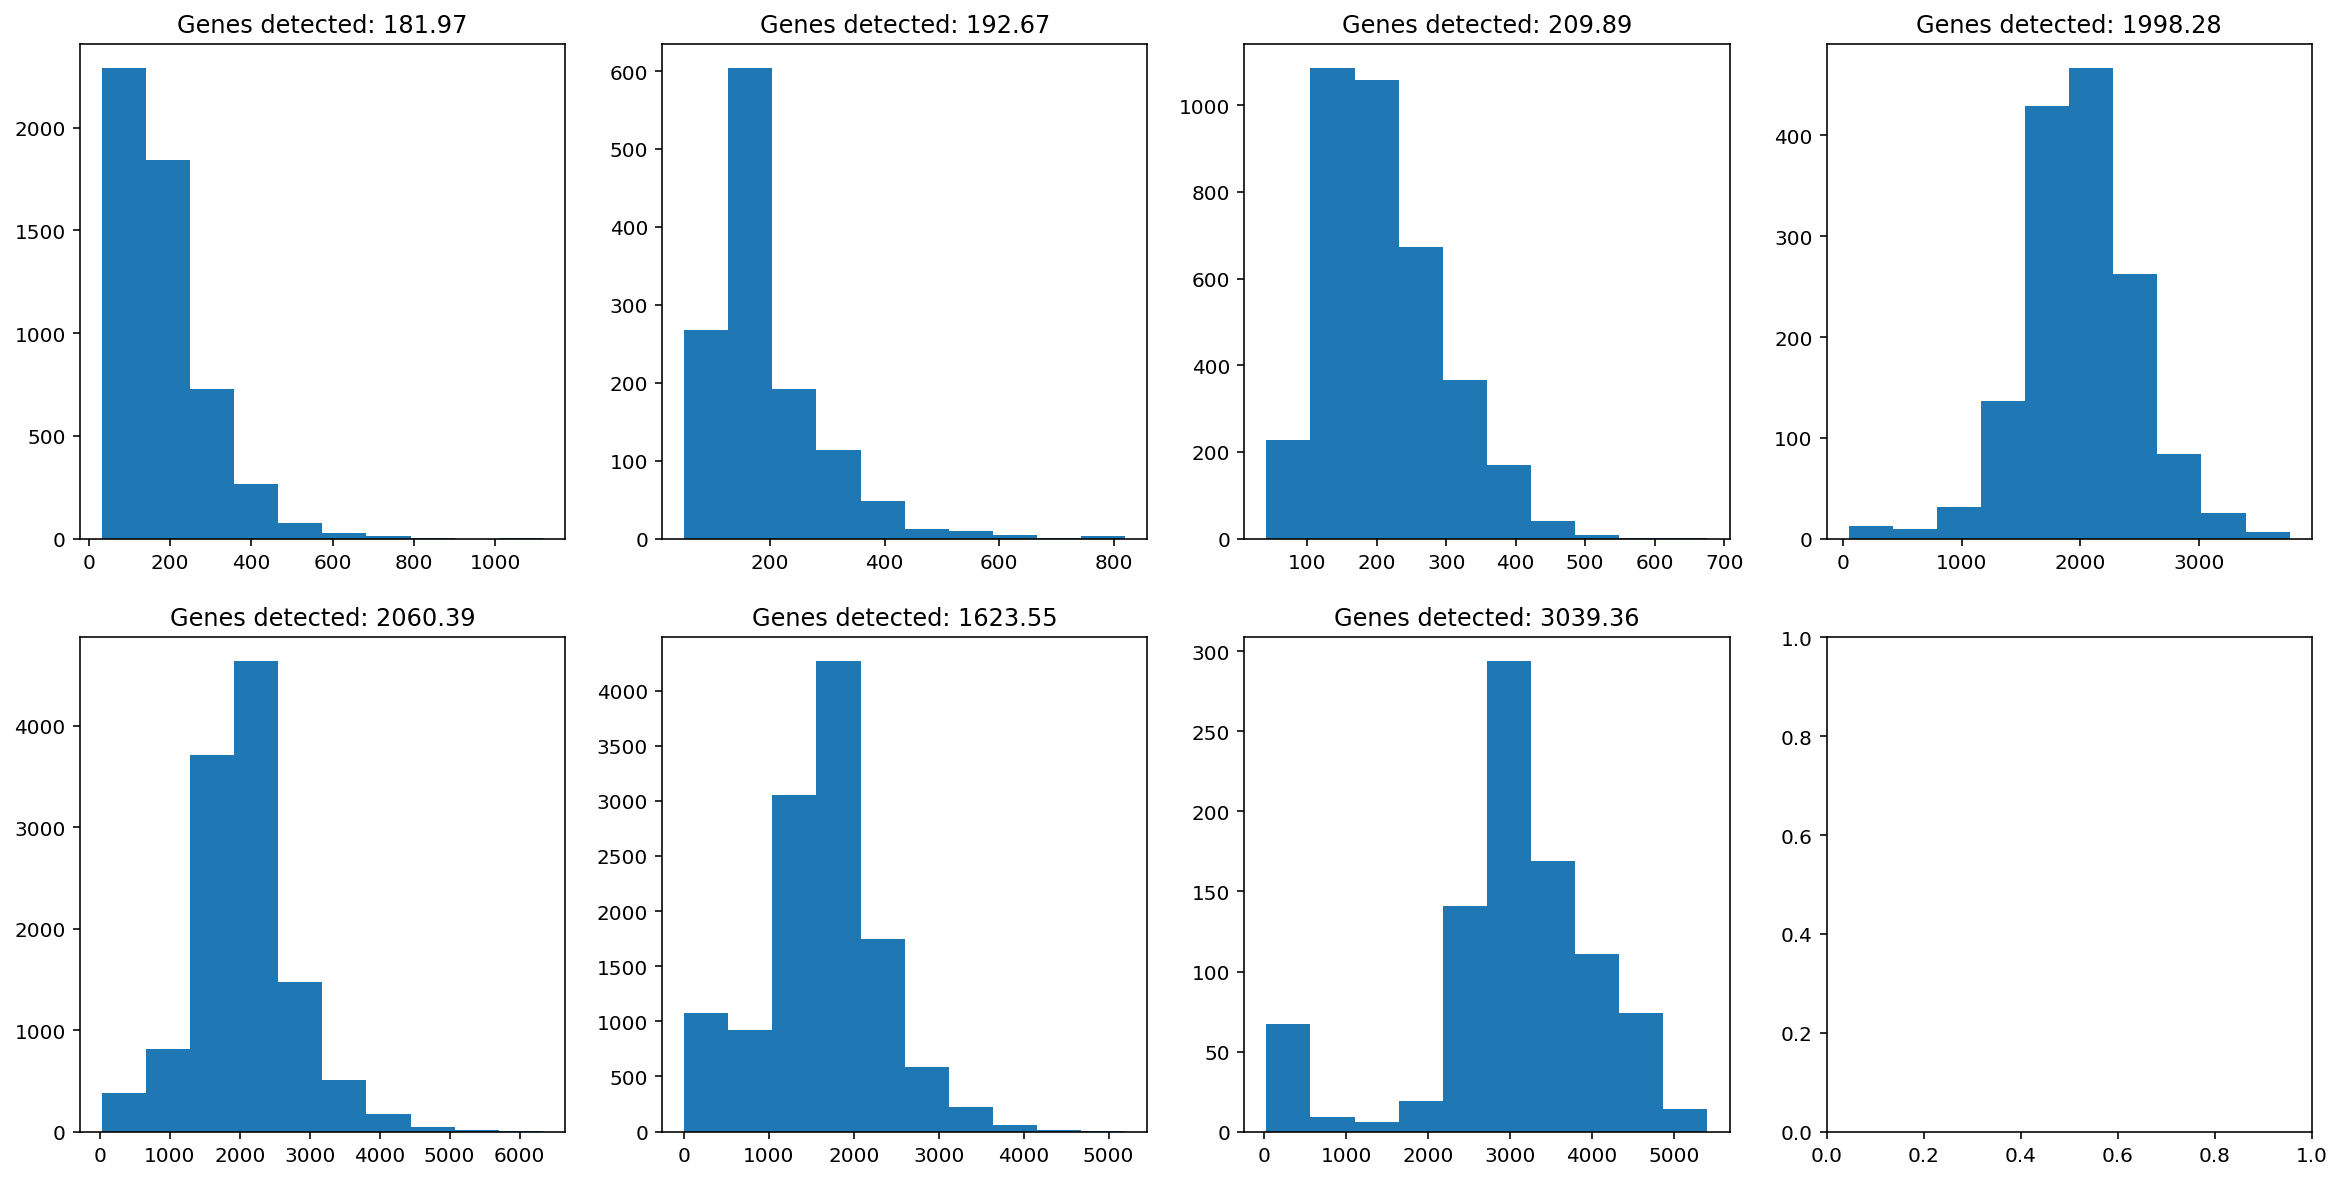

In [13]:
#For each matrix print histogram of each metric with mean in title
fig, axs = plt.subplots(2, 4,figsize=(20,10))
vals = np.sum(u_mats[0].todense().T > 0, axis=1)
axs[0, 0].hist(np.array(vals).flatten())
axs[0, 0].set_title('Genes detected: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[1].todense().T > 0, axis=1)
axs[0, 1].hist(np.array(vals).flatten())
axs[0, 1].set_title('Genes detected: '+   "{:.2f}".format(np.mean(vals.flatten()))) # str(np.mean(vals.flatten())))

vals = np.sum(u_mats[2].todense().T > 0, axis=1)
axs[0, 2].hist(np.array(vals).flatten())
axs[0, 2].set_title('Genes detected: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[3].todense().T > 0, axis=1)
axs[0, 3].hist(np.array(vals).flatten())
axs[0, 3].set_title('Genes detected: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[4].todense().T > 0, axis=1)
axs[1, 0].hist(np.array(vals).flatten())
axs[1, 0].set_title('Genes detected: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[5].todense().T > 0, axis=1)
axs[1, 1].hist(np.array(vals).flatten())
axs[1, 1].set_title('Genes detected: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[6].todense().T > 0, axis=1)
axs[1, 2].hist(np.array(vals).flatten())
axs[1, 2].set_title('Genes detected: '+ "{:.2f}".format(np.mean(vals.flatten()))) 


plt.show()


Unspliced Reads per gene

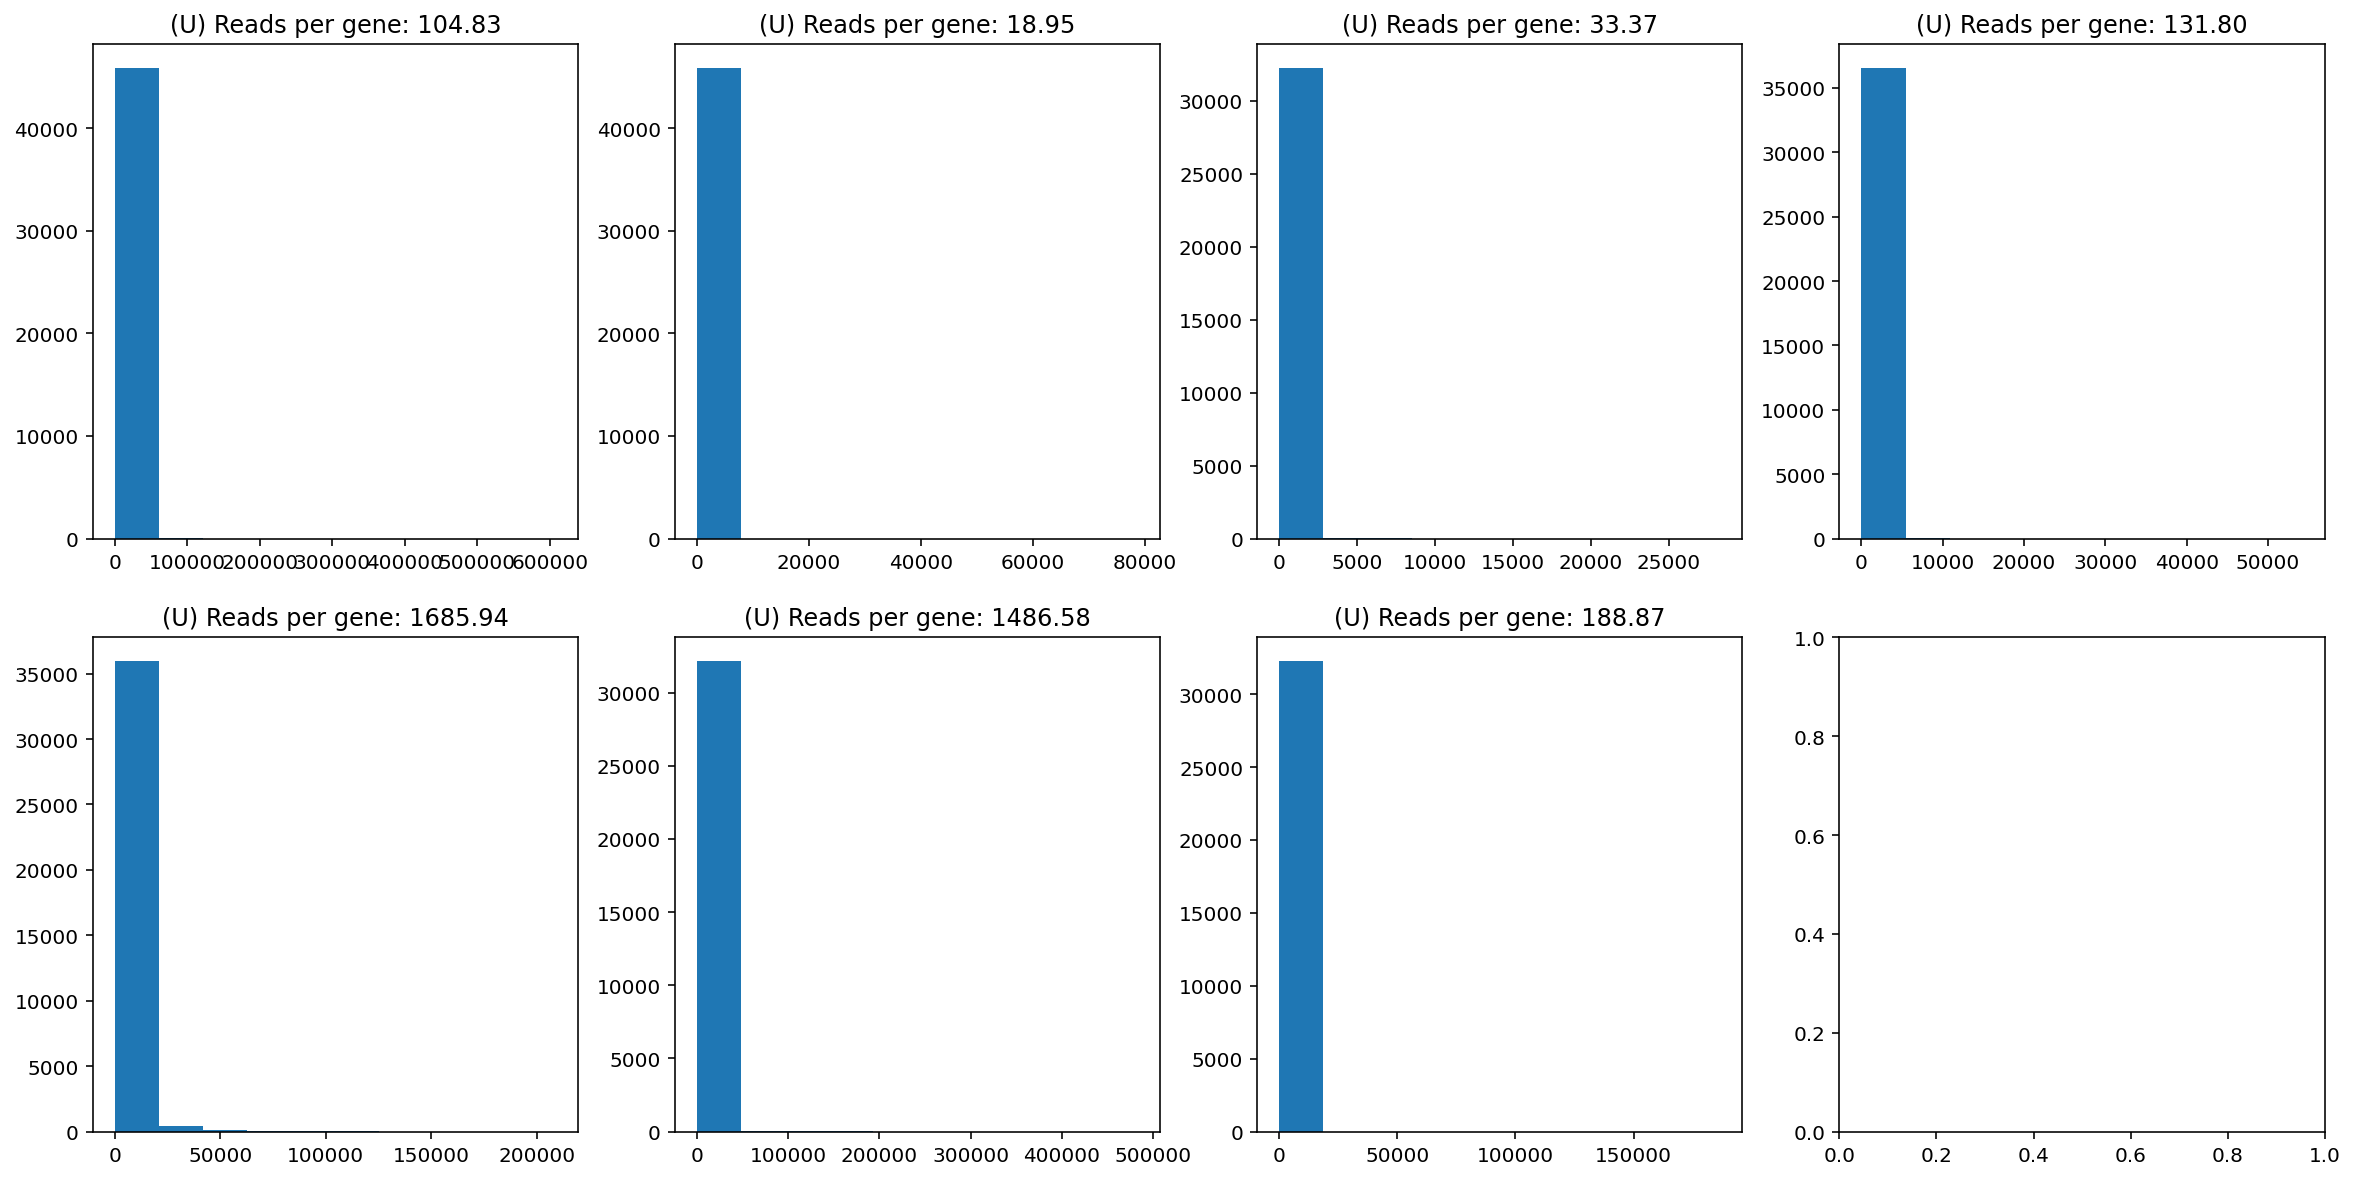

In [14]:

fig, axs = plt.subplots(2, 4,figsize=(20,10))
vals = np.sum(u_mats[0].todense().T,axis=0)
axs[0, 0].hist(np.array(vals).flatten())
axs[0, 0].set_title('(U) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[1].todense().T,axis=0)
axs[0, 1].hist(np.array(vals).flatten())
axs[0, 1].set_title('(U) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[2].todense().T,axis=0)
axs[0, 2].hist(np.array(vals).flatten())
axs[0, 2].set_title('(U) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[3].todense().T,axis=0)
axs[0, 3].hist(np.array(vals).flatten())
axs[0, 3].set_title('(U) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[4].todense().T,axis=0)
axs[1, 0].hist(np.array(vals).flatten())
axs[1, 0].set_title('(U) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[5].todense().T,axis=0)
axs[1, 1].hist(np.array(vals).flatten())
axs[1, 1].set_title('(U) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 


vals = np.sum(u_mats[6].todense().T,axis=0)
axs[1, 2].hist(np.array(vals).flatten())
axs[1, 2].set_title('(U) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 


plt.show()


Unspliced Reads per Cell per Gene

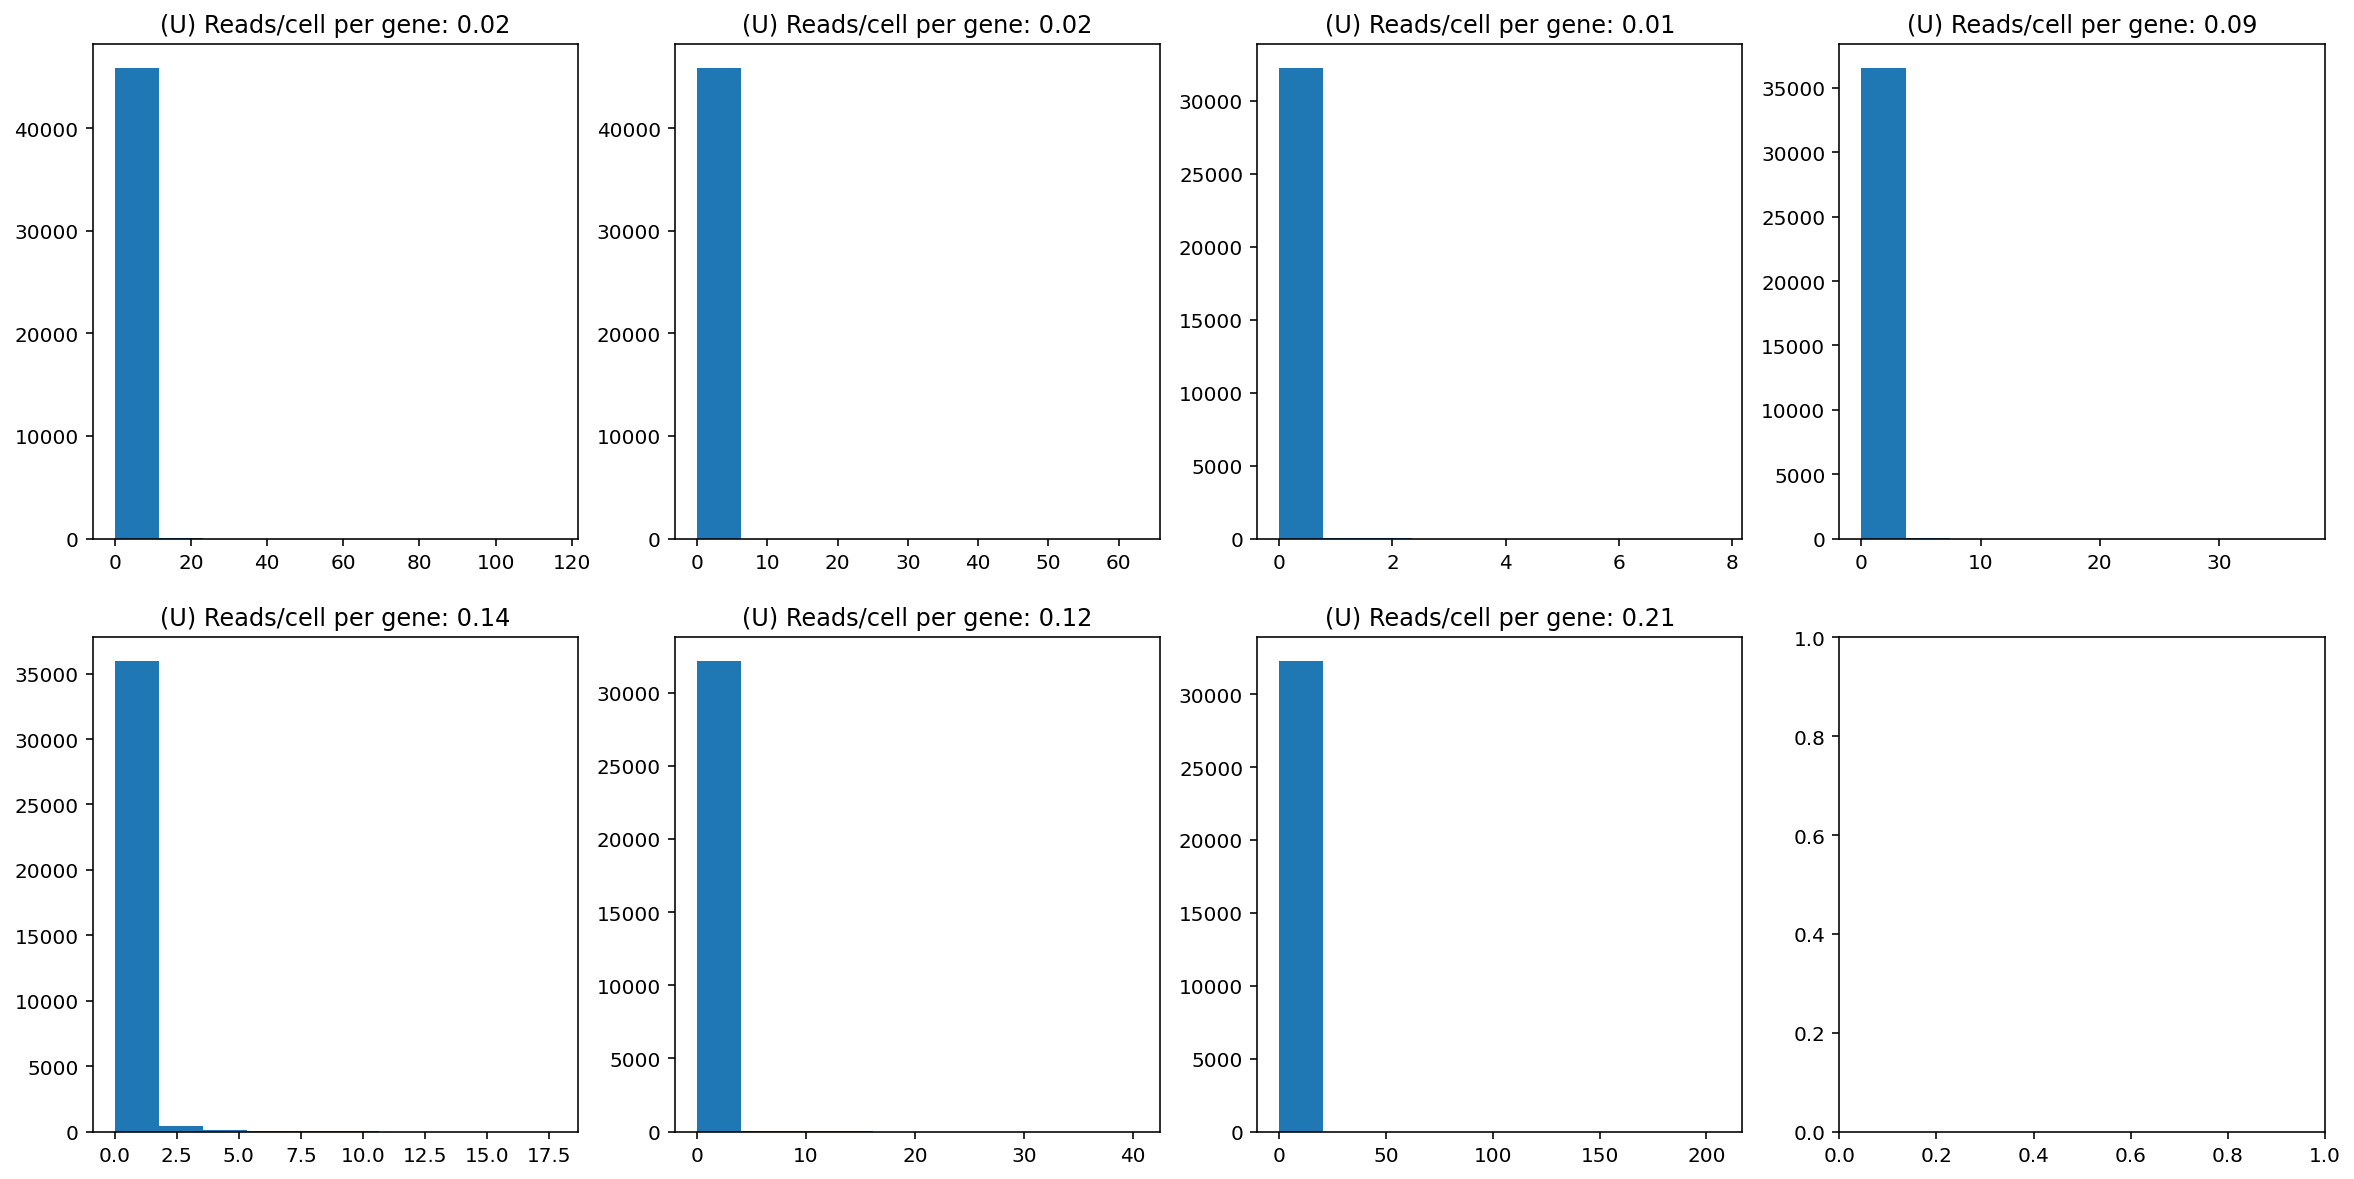

In [15]:

fig, axs = plt.subplots(2, 4,figsize=(20,10))
vals = np.sum(u_mats[0].todense().T,axis=0)/u_mats[0].todense().T.shape[0]
axs[0, 0].hist(np.array(vals).flatten())
axs[0, 0].set_title('(U) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[1].todense().T,axis=0)/u_mats[1].todense().T.shape[0]
axs[0, 1].hist(np.array(vals).flatten())
axs[0, 1].set_title('(U) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[2].todense().T,axis=0)/u_mats[2].todense().T.shape[0]
axs[0, 2].hist(np.array(vals).flatten())
axs[0, 2].set_title('(U) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[3].todense().T,axis=0)/u_mats[3].todense().T.shape[0]
axs[0, 3].hist(np.array(vals).flatten())
axs[0, 3].set_title('(U) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[4].todense().T,axis=0)/u_mats[4].todense().T.shape[0]
axs[1, 0].hist(np.array(vals).flatten())
axs[1, 0].set_title('(U) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(u_mats[5].todense().T,axis=0)/u_mats[5].todense().T.shape[0]
axs[1, 1].hist(np.array(vals).flatten())
axs[1, 1].set_title('(U) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 


vals = np.sum(u_mats[6].todense().T,axis=0)/u_mats[6].todense().T.shape[0]
axs[1, 2].hist(np.array(vals).flatten())
axs[1, 2].set_title('(U) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 


plt.show()



Spliced Reads per gene

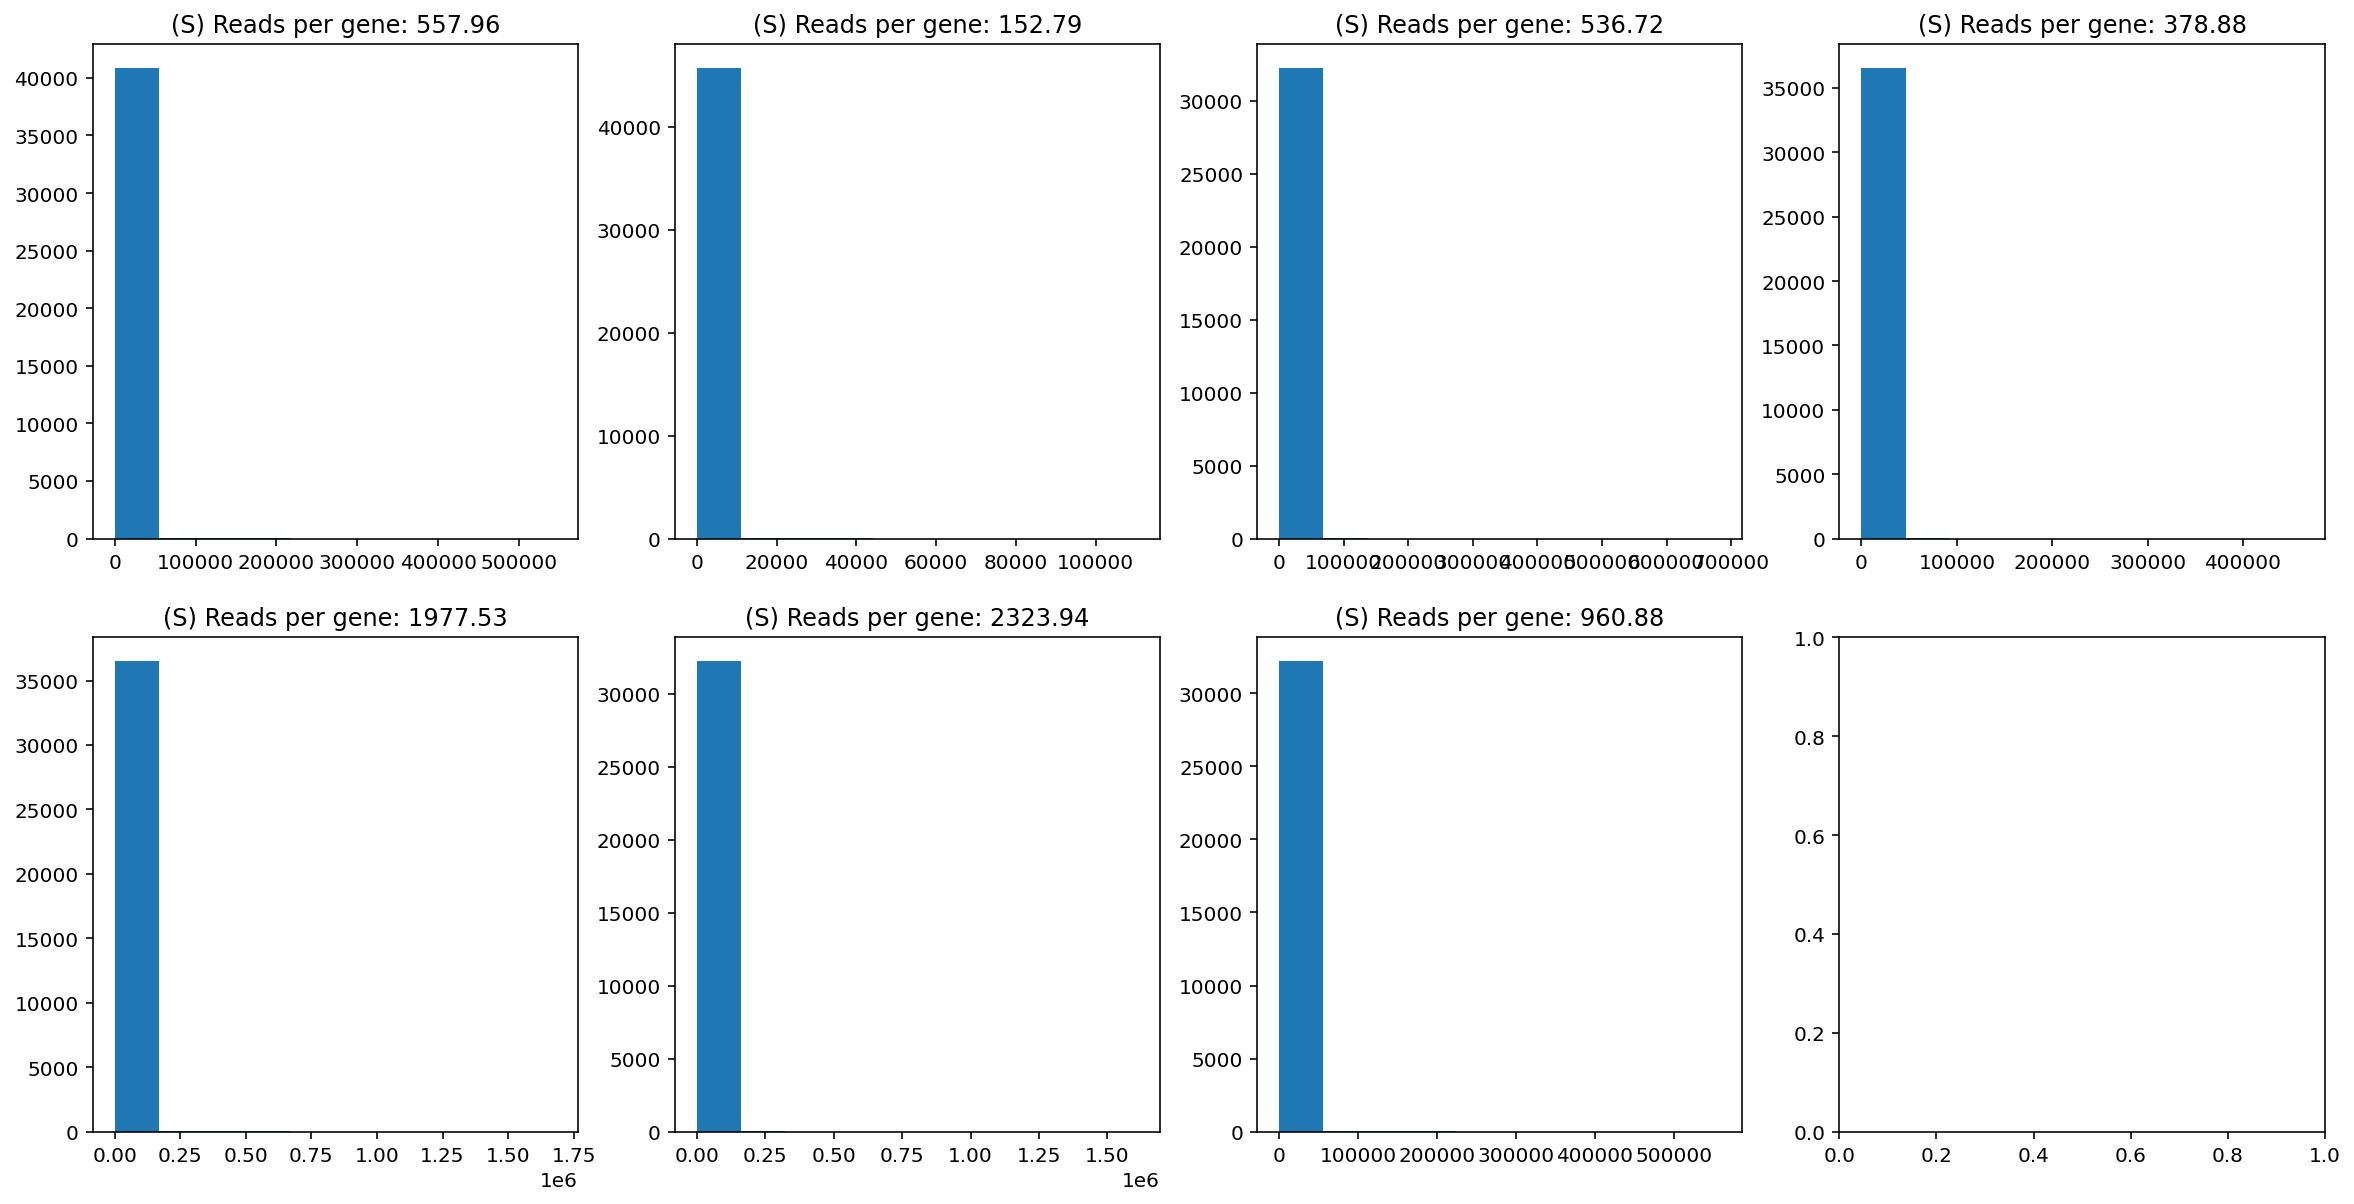

In [11]:

fig, axs = plt.subplots(2, 4,figsize=(20,10))
vals = np.sum(s_mats[0].todense().T,axis=0)
axs[0, 0].hist(np.array(vals).flatten())
axs[0, 0].set_title('(S) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(s_mats[1].todense().T,axis=0)
axs[0, 1].hist(np.array(vals).flatten())
axs[0, 1].set_title('(S) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(s_mats[2].todense().T,axis=0)
axs[0, 2].hist(np.array(vals).flatten())
axs[0, 2].set_title('(S) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(s_mats[3].todense().T,axis=0)
axs[0, 3].hist(np.array(vals).flatten())
axs[0, 3].set_title('(S) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(s_mats[4].todense().T,axis=0)
axs[1, 0].hist(np.array(vals).flatten())
axs[1, 0].set_title('(S) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(s_mats[5].todense().T,axis=0)
axs[1, 1].hist(np.array(vals).flatten())
axs[1, 1].set_title('(S) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(s_mats[6].todense().T,axis=0)
axs[1, 2].hist(np.array(vals).flatten())
axs[1, 2].set_title('(S) Reads per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 




plt.show()


Spliced Reads per Cell per Gene

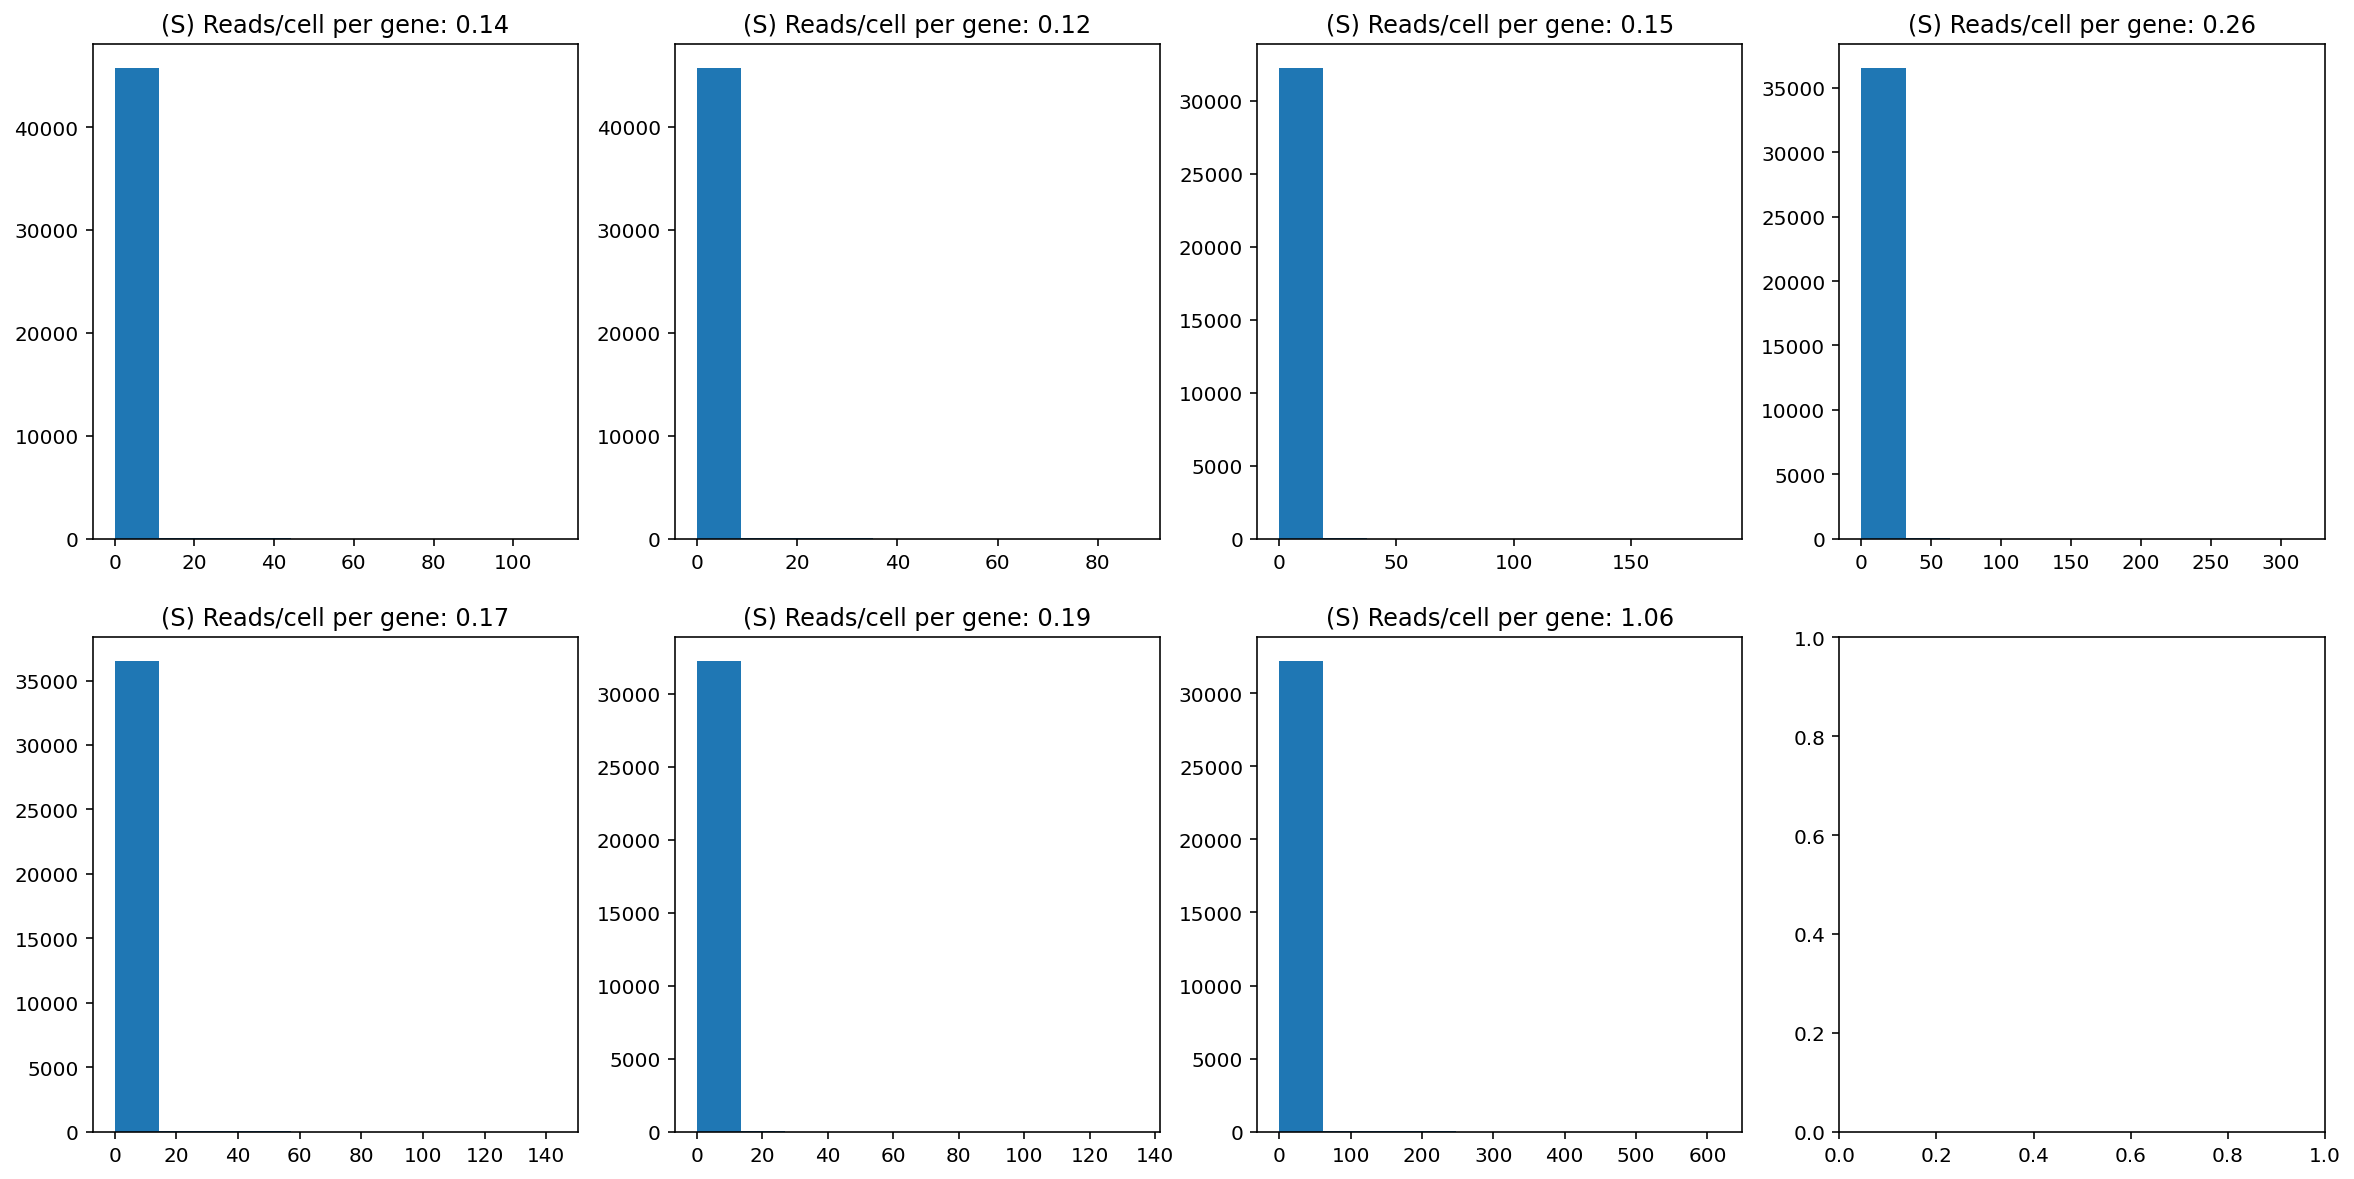

In [17]:

fig, axs = plt.subplots(2, 4,figsize=(20,10))
vals = np.sum(s_mats[0].todense().T,axis=0)/s_mats[0].todense().T.shape[0]
axs[0, 0].hist(np.array(vals).flatten())
axs[0, 0].set_title('(S) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(s_mats[1].todense().T,axis=0)/s_mats[1].todense().T.shape[0]
axs[0, 1].hist(np.array(vals).flatten())
axs[0, 1].set_title('(S) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(s_mats[2].todense().T,axis=0)/s_mats[2].todense().T.shape[0]
axs[0, 2].hist(np.array(vals).flatten())
axs[0, 2].set_title('(S) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(s_mats[3].todense().T,axis=0)/s_mats[3].todense().T.shape[0]
axs[0, 3].hist(np.array(vals).flatten())
axs[0, 3].set_title('(S) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(s_mats[4].todense().T,axis=0)/s_mats[4].todense().T.shape[0]
axs[1, 0].hist(np.array(vals).flatten())
axs[1, 0].set_title('(S) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

vals = np.sum(s_mats[5].todense().T,axis=0)/s_mats[5].todense().T.shape[0]
axs[1, 1].hist(np.array(vals).flatten())
axs[1, 1].set_title('(S) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 


vals = np.sum(s_mats[6].todense().T,axis=0)/s_mats[6].todense().T.shape[0]
axs[1, 2].hist(np.array(vals).flatten())
axs[1, 2].set_title('(S) Reads/cell per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 



plt.show()



S/U (Avg) Ratio per Gene

In [12]:

# fig, axs = plt.subplots(2, 3,figsize=(20,10))
# vals = np.sum(u_mats[0].todense().T,axis=0)/np.sum(s_mats[0].todense().T,axis=0)
# axs[0, 0].hist(np.array(vals).flatten())
# axs[0, 0].set_title('S/U per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

# vals = np.sum(u_mats[1].todense().T,axis=0)/np.sum(s_mats[1].todense().T,axis=0)
# axs[0, 1].hist(np.array(vals).flatten())
# axs[0, 1].set_title('S/U per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

# vals = np.sum(u_mats[2].todense().T,axis=0)/np.sum(s_mats[2].todense().T,axis=0)
# axs[0, 2].hist(np.array(vals).flatten())
# axs[0, 2].set_title('S/U per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

# vals = np.sum(u_mats[3].todense().T,axis=0)/np.sum(s_mats[3].todense().T,axis=0)
# axs[1, 0].hist(np.array(vals).flatten())
# axs[1, 0].set_title('S/U per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

# vals = np.sum(u_mats[4].todense().T,axis=0)/np.sum(s_mats[4].todense().T,axis=0)
# axs[1, 1].hist(np.array(vals).flatten())
# axs[1, 1].set_title('S/U per gene: '+ "{:.2f}".format(np.mean(vals.flatten()))) 

# plt.show()

for i in range(len(u_mats)):
    
    s_sum = np.array(np.sum(s_mats[i].todense().T,axis=0))
    u_sum = np.array(np.sum(u_mats[i].todense().T,axis=0))
 
    
    print('S/U Ratio: '+"{:.2f}".format(np.mean(s_sum)/np.mean(u_sum))+ " for "+paths[i])


S/U Ratio: 10.48 for /home/tchari/counts/clytia_stim/loom/clytia_SWall.loom
S/U Ratio: 8.06 for /home/tchari/counts/clytia_stim/loom/clytiaNematocyte.loom
S/U Ratio: 16.08 for /home/tchari/counts/gehring_nsc/loom/nsc45.loom
S/U Ratio: 2.87 for /home/tchari/counts/replogle_crispr/loom/crisprsgNegCtrl02093a_sgNegCtrl3b.loom
S/U Ratio: 1.17 for /home/tchari/gg_looms/pbmcs_10x.loom
S/U Ratio: 1.56 for /home/tchari/gg_looms/neurons_10k.loom
S/U Ratio: 5.09 for /home/tchari/gg_looms/desai_dmso.loom
S/U Ratio: 5.62 for /home/tchari/counts/hagai_lps/24754_6/counts_filtered/adata_24754_6.loom


### **Set global variables**

In [6]:
#data_path = '/home/tchari/counts/'

#in_fold = 'loom/'
out_fold = '/home/tchari/counts/QC/loom_res/'

transcriptomes = ['/home/tchari/clytiaRef/tc_220309_genome_polyA_cum_clytia',
                 '/home/tchari/clytiaRef/tc_220309_genome_polyA_cum_clytia',
                 'gg_200524_mouse_genome_polyA_cum_1',
                 'gg_200525_genome_polyA_cum_3',
                 'gg_200525_genome_polyA_cum_3',
                 'gg_200524_mouse_genome_polyA_cum_1',
                 'gg_200524_mouse_genome_polyA_cum_1',
                 'gg_200524_mouse_genome_polyA_cum_1',
                '/home/tchari/clytiaRef/tc_220309_genome_polyA_cum_clytia']

data_paths = ['/home/tchari/counts/clytia_stim/loom/',
        '/home/tchari/counts/clytia_stim/loom/',
        '/home/tchari/counts/gehring_nsc/loom/',
        '/home/tchari/counts/replogle_crispr/loom/',
        '/home/tchari/gg_looms/',
        '/home/tchari/gg_looms/',
        '/home/tchari/gg_looms/',
        '/home/tchari/counts/hagai_lps/24754_6/counts_filtered/',
        '/home/tchari/counts/clytia_stim/loom/']

looms = ['clytia_SWall',
        'clytiaNematocyte',
        'nsc45',
        'crisprsgNegCtrl02093a_sgNegCtrl3b',
        'pbmcs_10x',
        'neurons_10k',
        'desai_dmso',
        'adata_24754_6',
        'clytiaNeural']
#Dataset-dependent

atts = ["[['spliced','unspliced','Gene','Barcode']]", "[['spliced','unspliced','Gene','Barcode']]",
        "[['spliced','unspliced','Gene','Barcode']]", "[['spliced','unspliced','Gene','Barcode']]",
        "[['spliced','unspliced','gene_name','barcode']]","[['spliced','unspliced','gene_name','barcode']]",
        "[['spliced','unspliced','gene_name','barcode']]",
       "[['spliced','unspliced','gene_name','barcode']]",
       "[['spliced','unspliced','Gene','Barcode']]"]


override='QCRuns' #First run only

creator = 'tc'

In [27]:
# selGenes = creator+'_'+override+'_selected_genes.csv'
# filtGenes = creator+'_'+override+'_filtered_genes.csv'

In [26]:
!mkdir {out_fold}

### **Conduct gene selection and parameter fitting across Negative Controls**

In [27]:
# genRunInput(fname=looms[0]+'_input.txt',dataDir =data_path+proj_fold+in_fold,
#             outDir=data_path+proj_fold+out_fold,loomName = looms[0],
#             tranName = transcriptome,override=override)

In [7]:
for i in range(len(data_paths)):
    genRunInput(fname=looms[i]+'_input.txt',dataDir =data_paths[i],
                outDir=out_fold,loomName = looms[i], attList=atts[i],
                tranName = transcriptomes[i],override=override)

In [8]:
!cat {looms[-1]+'_input.txt'}

#Parameter input for CME inference 
dataset_directory : /home/tchari/counts/clytia_stim/loom/ : folder with dataset loom files
result_directory : /home/tchari/counts/QC/loom_res/ : where to put the result folder
loom_filenames : clytia_SW_KClNeural : filenames to integrate
transcriptome_filename : /home/tchari/clytiaRef/tc_220309_genome_polyA_cum_clytia : transcriptome location
polyA_threshold : 15 : minimum polyA count to use for sampling function
transcriptome_ind : 0 : column of transcriptome file to use (lengths if 0, polyA count if 1)
filter_param : 0.01, 0.01, 350, 350, 3, 3 : min threshold for mean, max threshold for max, mean threshold for max; odd is U, even is S
all_prev_results : : result files with gene names to exclude
attribute_names : [['spliced','unspliced','Gene','Barcode']] : list or list of lists with loom attribute names
gene_sel_seed : 42 : gene selection seed
n_gen : 5000 : number of genes to select
IND : 0 : loom_filename to analyze
gene_list :  : set of result f

In [ ]:
#Re-run to print outputs for all loom files
for i in range(len(data_paths)):
    inference_workflow(looms[i]+'_input.txt')
#not very many highly expressed gene

### Control Result Processing

Import the results. This interface can accept multiple inputs: for example, it's possible to use the same grid for searches over several sets of genes and integrate them in downstream analysis. The names of the strings in the list should be in the format `./result_dir/result.pickle`. 

In [10]:
# a e s t h e t i c s

#all
col_gold = [203/255,197/255,149/255]
col_gray = [116/255,112/255,113/255]
col_red = [212/255,107/255,75/255]

### SI figures
ms = 0.7
lw = ms
ms_fail = 1
alf = 0.3
alf_fail = 0.5
sifig_aesth = (ms,lw,ms_fail,alf,alf_fail)

### Body figures
ms = 2
lw = ms
ms_fail = 2
alf = 0.3
alf_fail = 0.8
msfig_aesth = (ms,lw,ms_fail,alf,alf_fail)

markerstyle = None

In [11]:
outputs = glob.glob(out_fold+creator+'_'+override+'_*/result.pickle')

In [12]:
def import_precomputed_(filestring):
    with open(filestring,'rb') as f:
        precomp = pickle.load(f)
    return precomp

def check_at_bounds(result_data,phys_params,thr=0.01):
    x = np.any(np.logical_or(
        result_data.search_params.lb_log+thr > phys_params,
        result_data.search_params.ub_log-thr < phys_params) ,1)
    return x


In [13]:
def get_name(fname):
    start = fname.find(out_fold+creator+'_'+override+'_') + len(out_fold+creator+'_'+override+'_')
    end = fname.find("_10x11")
    substring = fname[start:end]
    
    return substring

out_names = [get_name(i) for i in outputs]
out_names


['clytia_SW_KClNematocyte',
 'pbmcs_10x',
 'crisprsgNegCtrl02093a_sgNegCtrl3b',
 'adata_24754_6',
 'desai_dmso',
 'clytia_SWall',
 'clytiaNeural',
 'clytiaNematocyte',
 'nsc45',
 'clytia_SW_KClNeural',
 'neurons_10k']

In [14]:
#Read in outputs
results = []
for i in outputs:
     results += [import_datasets([i])]

results[1].raw_S.shape

(5000, 11756)

In [35]:
# vals = np.sum(results[1].raw_S,axis = 0)
# vals.shape

(5251,)

In [34]:
# np.sum(results[i].raw_U,axis = 1).shape

(220,)

#### **Do chi-squared correction (reject genes with bad fits) and re-evaluate best params**

clytia_SW_KClNematocyte
pbmcs_10x
crisprsgNegCtrl02093a_sgNegCtrl3b
adata_24754_6
desai_dmso
clytia_SWall
clytiaNeural
clytiaNematocyte
nsc45
clytia_SW_KClNeural
neurons_10k


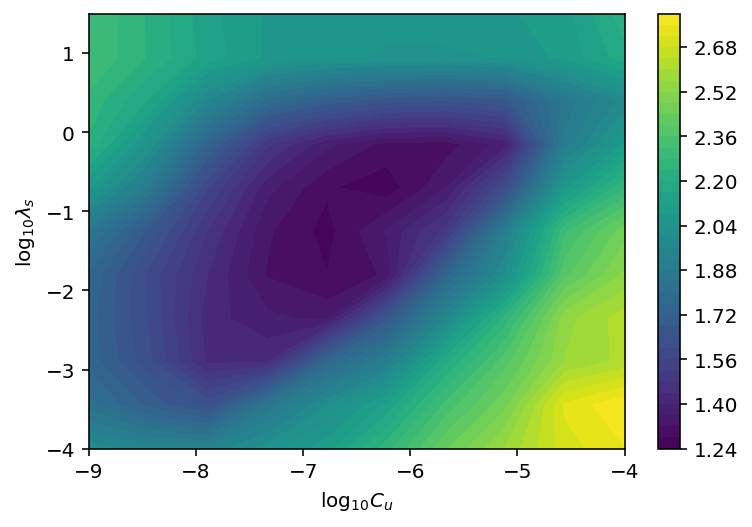

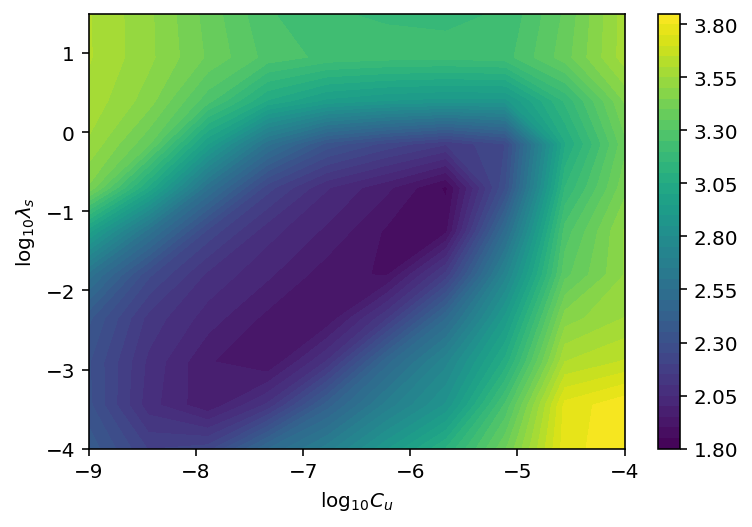

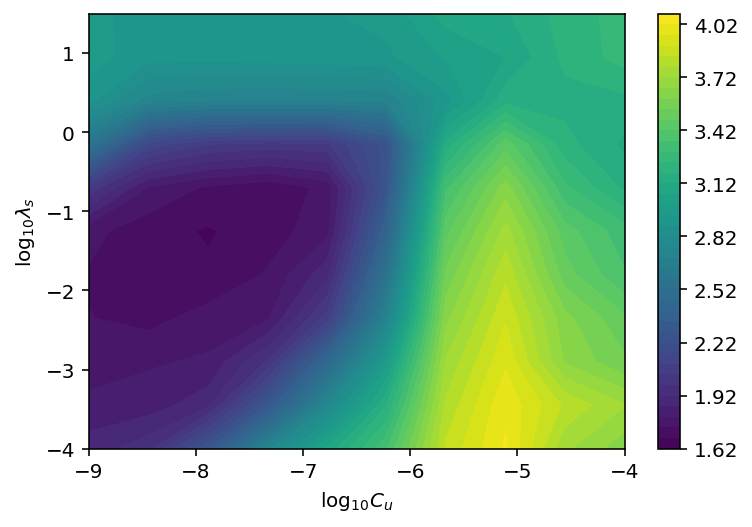

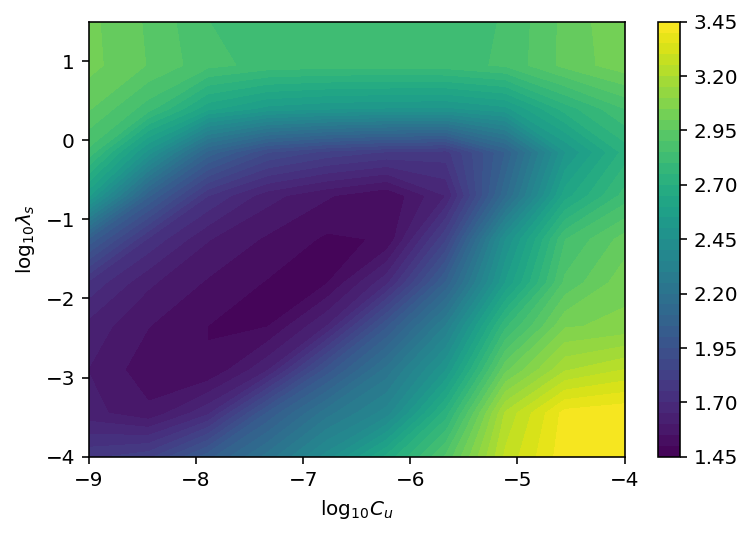

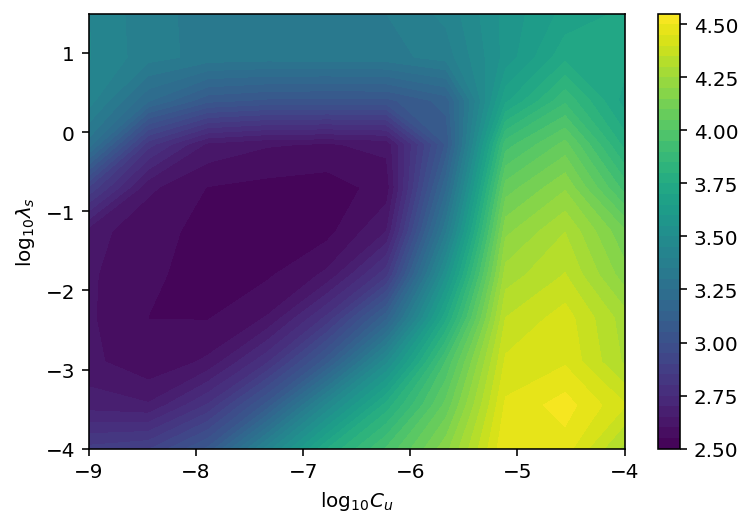

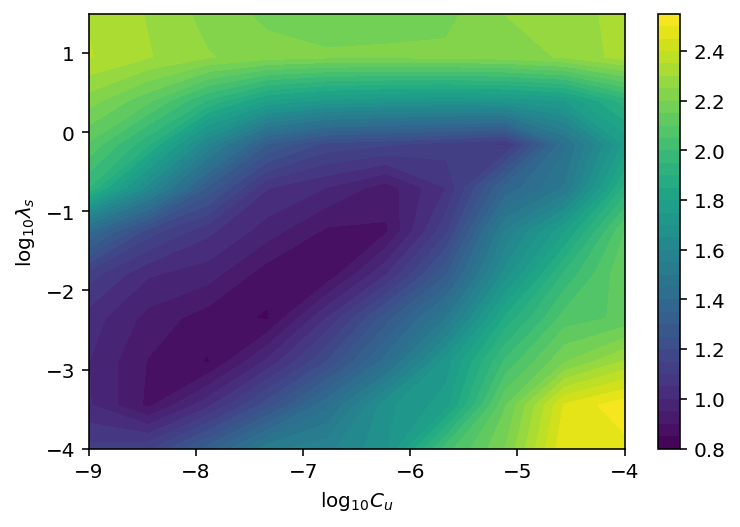

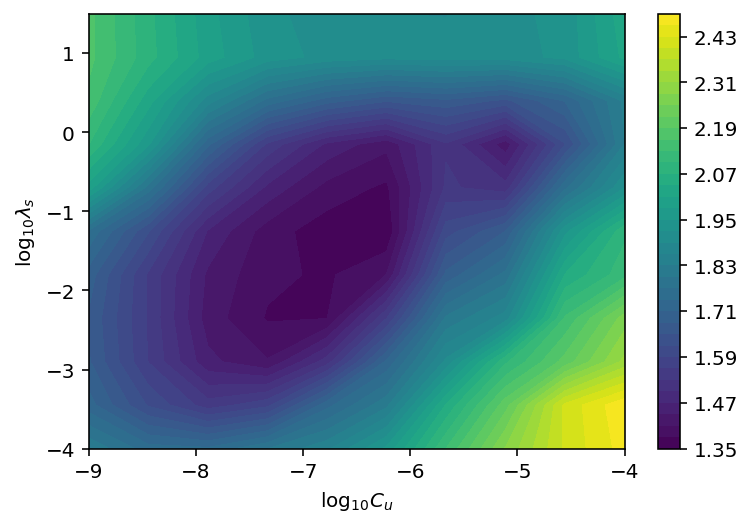

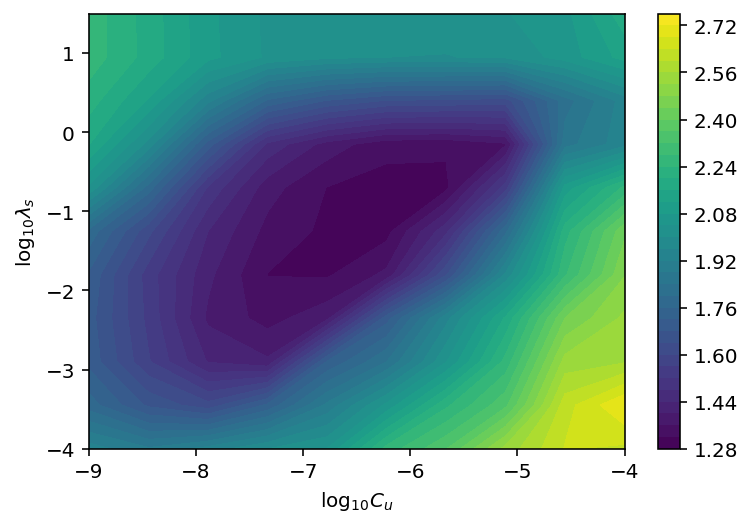

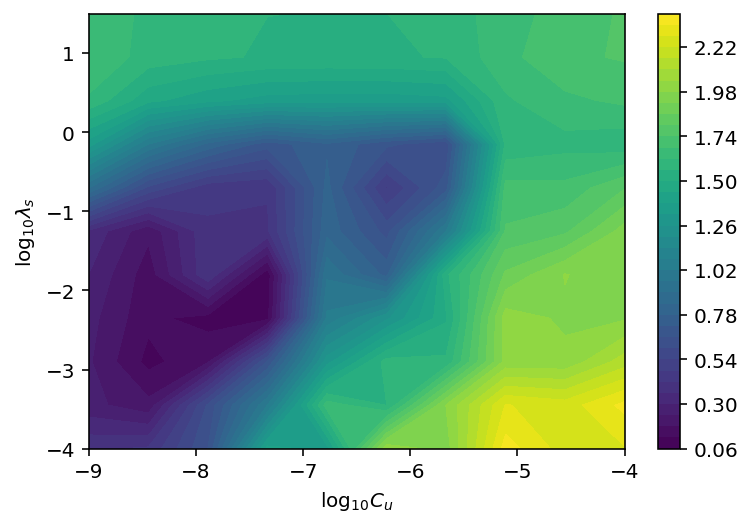

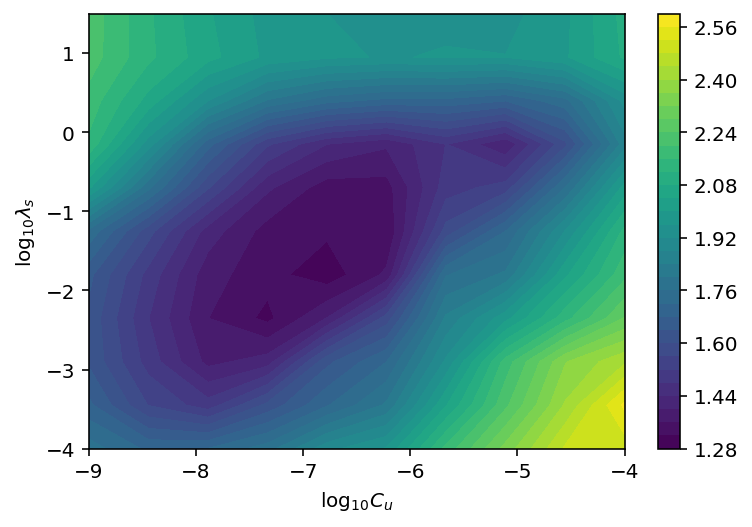

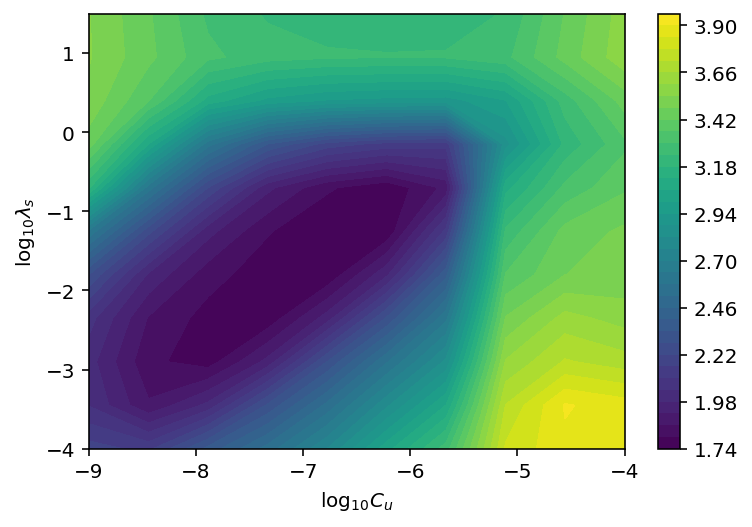

In [15]:
for i in range(0,len(results)):
    print(out_names[i])
    landscape_viz(results[i])

In [16]:
#Set some optimal samp params before chisq

for i in range(0,len(results)):
    results[i].find_best_params() 
    print(results[i].best_samp_params)

(-6.222222222222222, -0.6999999999999997)
(-5.666666666666666, -0.6999999999999997)
(-7.888888888888889, -1.25)
(-6.777777777777778, -1.25)
(-6.777777777777778, -0.6999999999999997)
(-7.333333333333333, -2.3499999999999996)
(-6.222222222222222, -1.25)
(-6.222222222222222, -1.25)
(-7.333333333333333, -1.7999999999999998)
(-6.777777777777778, -1.7999999999999998)
(-6.777777777777778, -1.25)


In [17]:
#Run chisq, set rejected genes
 
for i in range(0,len(results)):
    print(i)
    chisq_gen(results[i],EPS=1e-20) #1e-12 too large --> numerical discrepancies b/w obs vs expect freqs
    compute_sigma(results[i])
    chisq_best_param_correction(results[i],overwrite=True,EPS=1e-20) #Copy github and change params

0
1
2
3
4
5
6
7
8
9
10


In [39]:
for i in range(0,len(results)): #jellydatasets
    print(out_names[i] + ' New params: ', results[i].best_samp_params)

pbmcs_10x New params:  (-5.666666666666666, -0.6999999999999997)
crisprsgNegCtrl02093a_sgNegCtrl3b New params:  (-7.888888888888889, -1.7999999999999998)
adata_24754_6 New params:  (-6.777777777777778, -1.25)
desai_dmso New params:  (-6.777777777777778, -0.6999999999999997)
clytia_SWall New params:  (-6.222222222222222, -1.25)
clytiaNeural New params:  (-6.222222222222222, -1.25)
clytiaNematocyte New params:  (-6.222222222222222, -1.25)
nsc45 New params:  (-7.333333333333333, -1.7999999999999998)
neurons_10k New params:  (-6.777777777777778, -1.25)


In [18]:
for i in range(0,len(results)):
    perc = np.round(np.sum(results[i].gene_rej)/results[i].n_gen,3)*100
    print(out_names[i]+': '+str(np.sum(results[i].gene_rej))+' genes of '+str(results[i].n_gen)+' ('+ str(perc)+'%) have been rejected by chi-square.')
    print()
    
    

clytia_SW_KClNematocyte: 42 genes of 254 (16.5%) have been rejected by chi-square.

pbmcs_10x: 410 genes of 5000 (8.200000000000001%) have been rejected by chi-square.

crisprsgNegCtrl02093a_sgNegCtrl3b: 113 genes of 1595 (7.1%) have been rejected by chi-square.

adata_24754_6: 207 genes of 2067 (10.0%) have been rejected by chi-square.

desai_dmso: 34 genes of 3832 (0.8999999999999999%) have been rejected by chi-square.

clytia_SWall: 179 genes of 354 (50.6%) have been rejected by chi-square.

clytiaNeural: 19 genes of 152 (12.5%) have been rejected by chi-square.

clytiaNematocyte: 32 genes of 211 (15.2%) have been rejected by chi-square.

nsc45: 15 genes of 110 (13.600000000000001%) have been rejected by chi-square.

clytia_SW_KClNeural: 26 genes of 209 (12.4%) have been rejected by chi-square.

neurons_10k: 260 genes of 5000 (5.2%) have been rejected by chi-square.



#### Look at parameters fits (Why do most look like there's no length bias?)

pbmcs_10x
crisprsgNegCtrl02093a_sgNegCtrl3b
adata_24754_6
desai_dmso
clytia_SWall
clytiaNeural
clytiaNematocyte
nsc45
neurons_10k


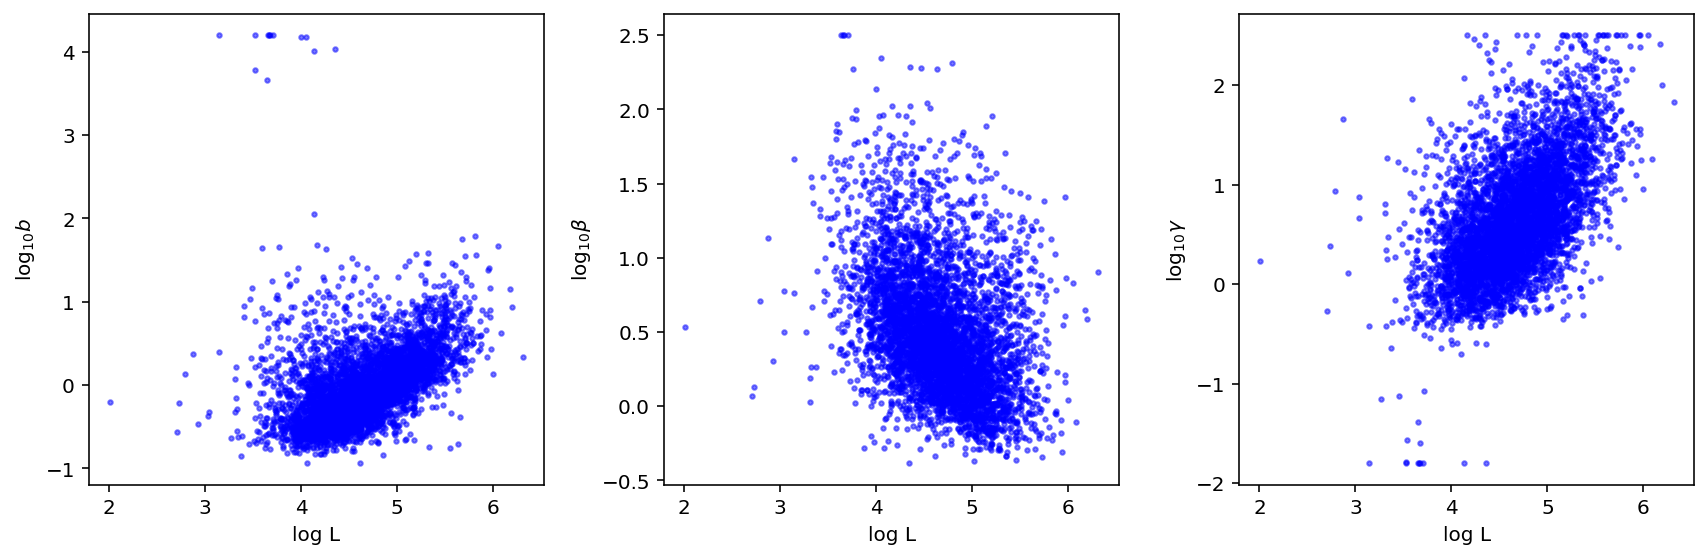

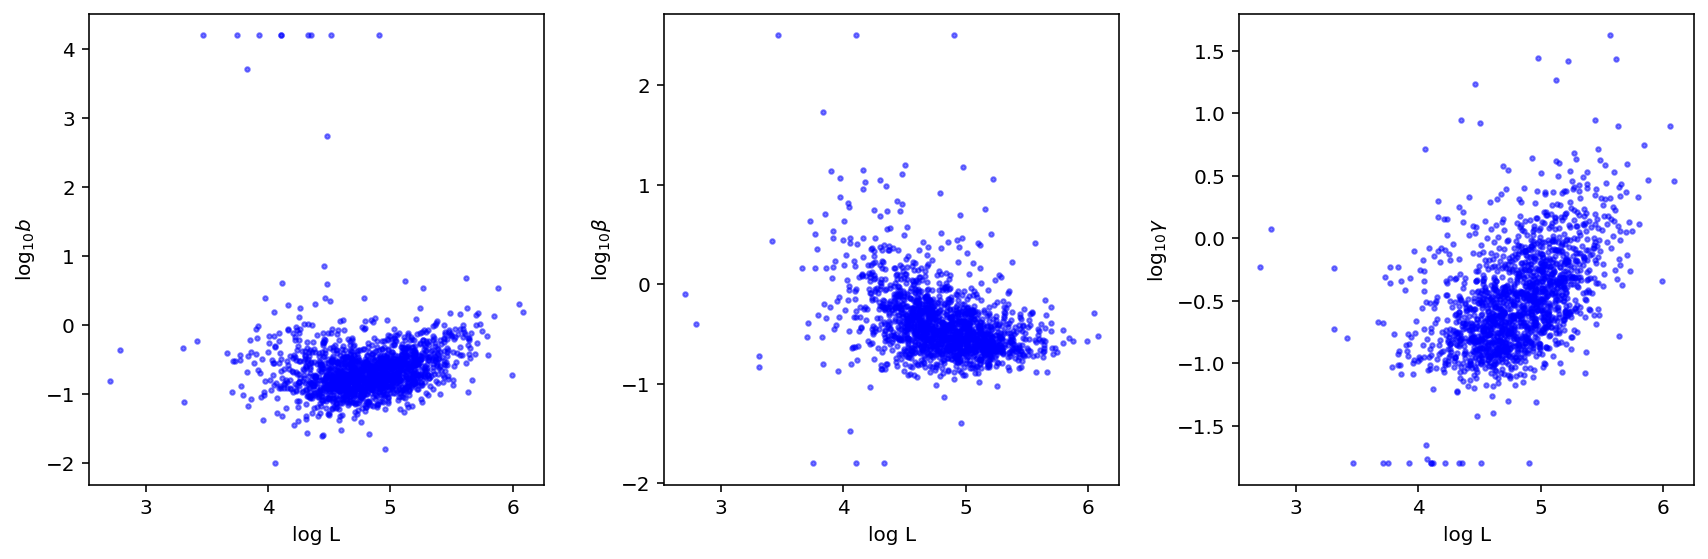

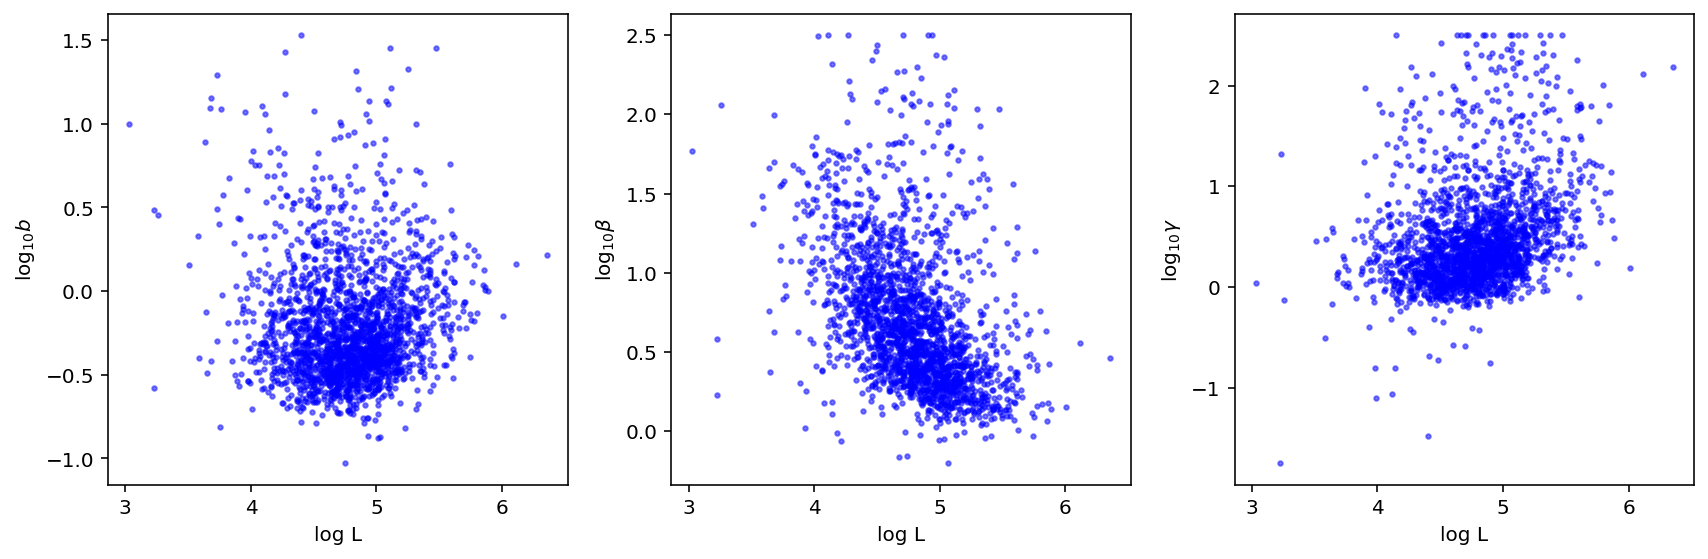

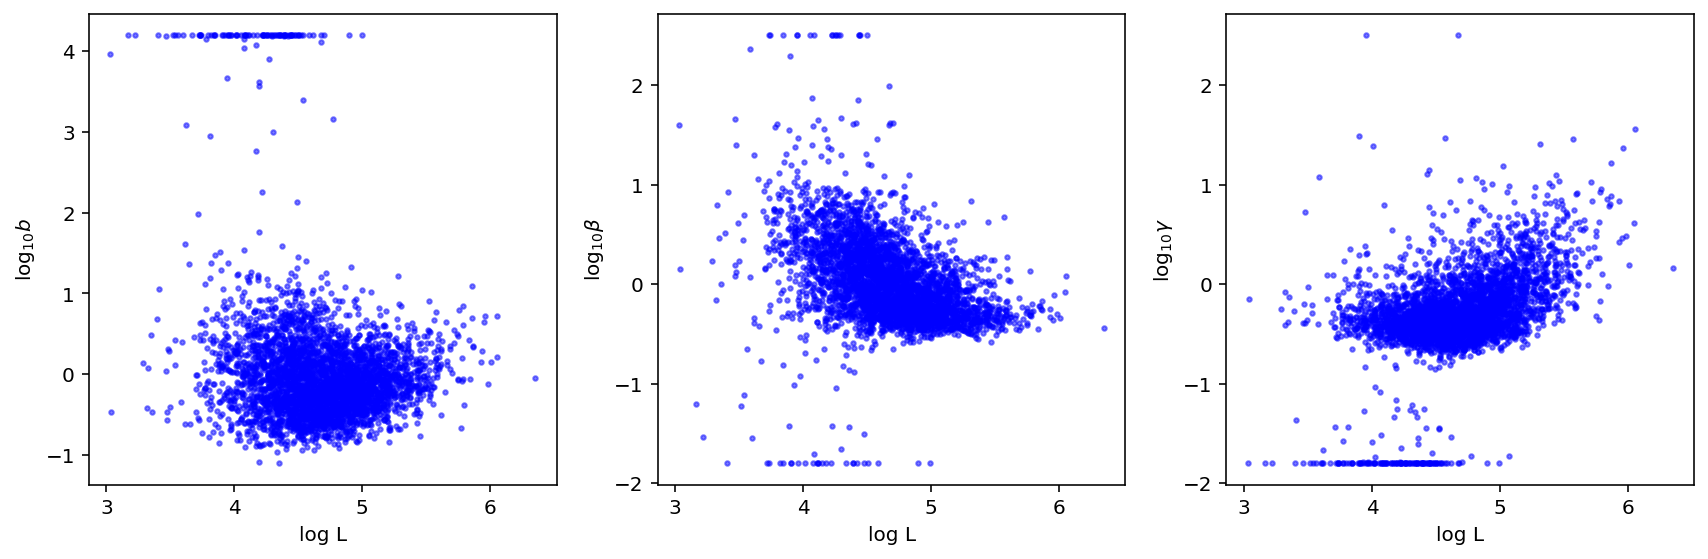

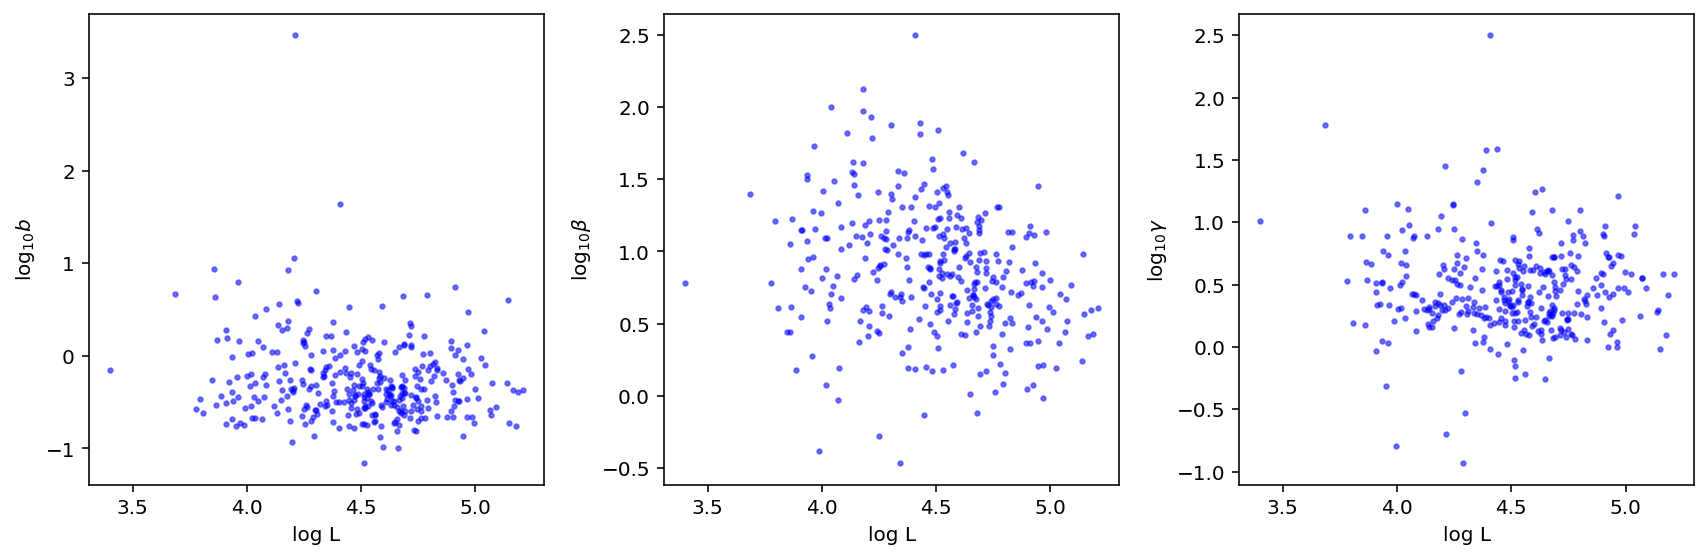

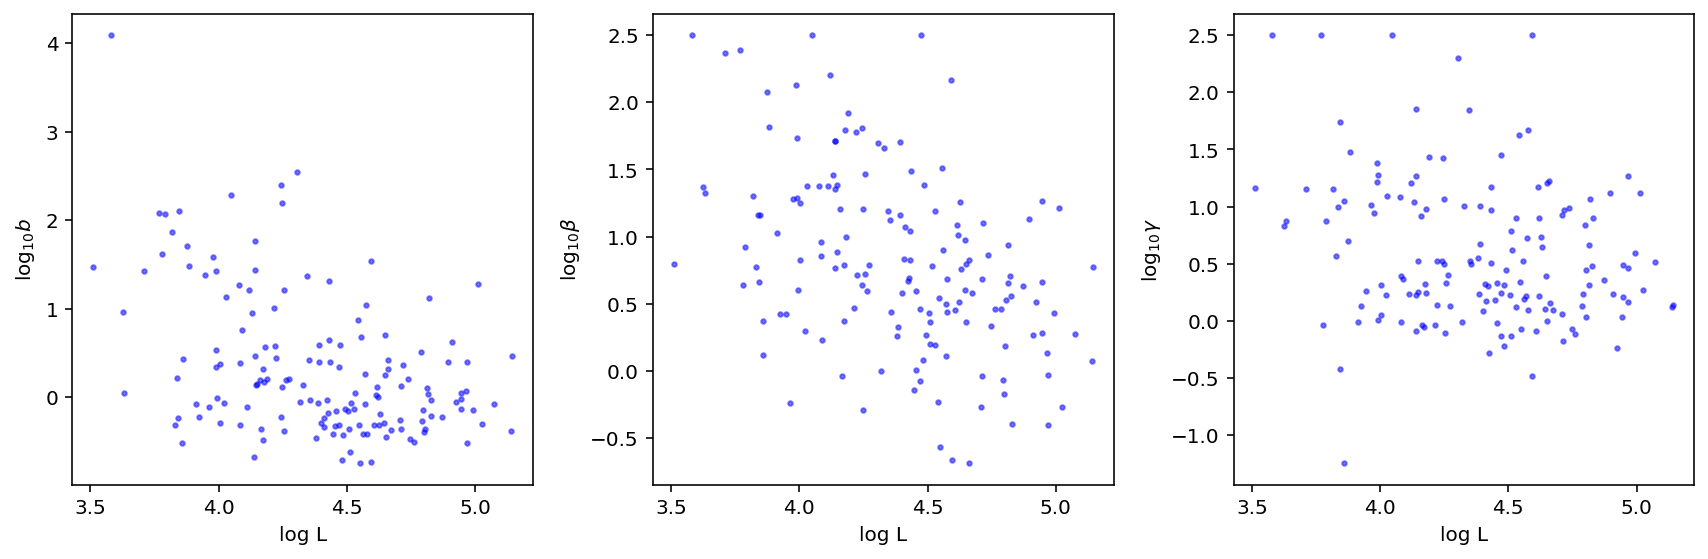

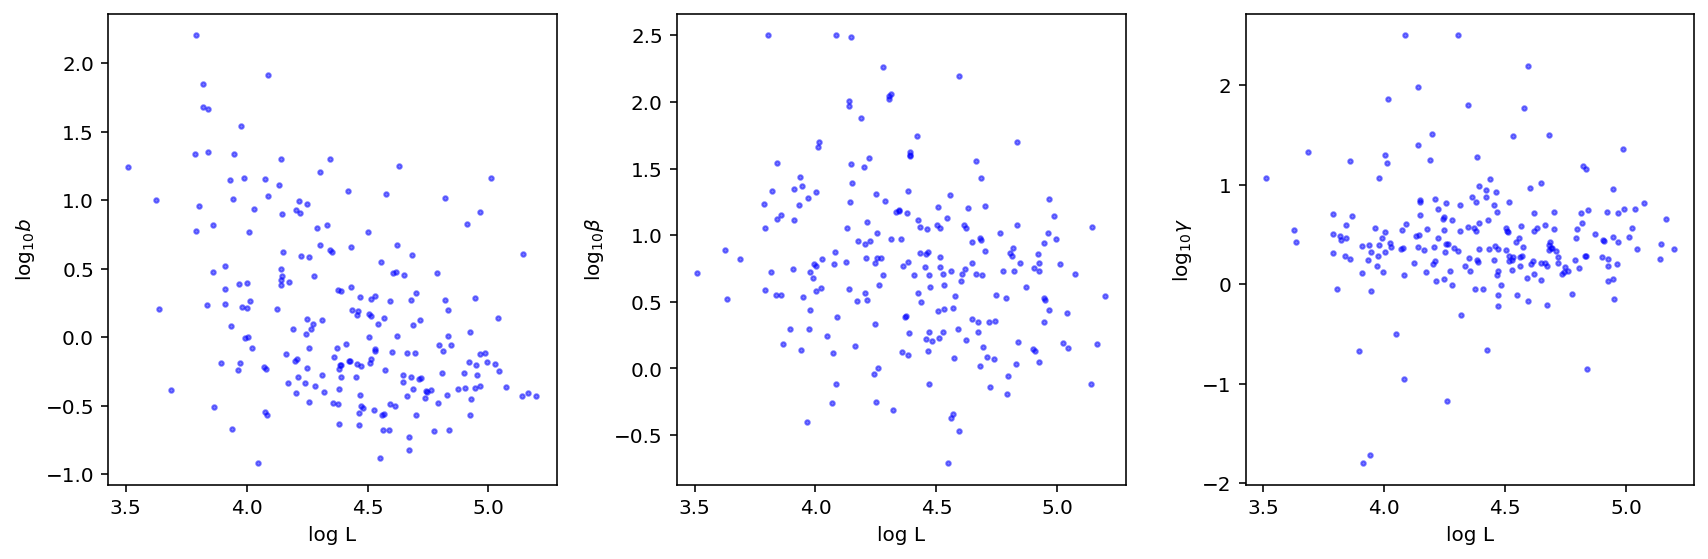

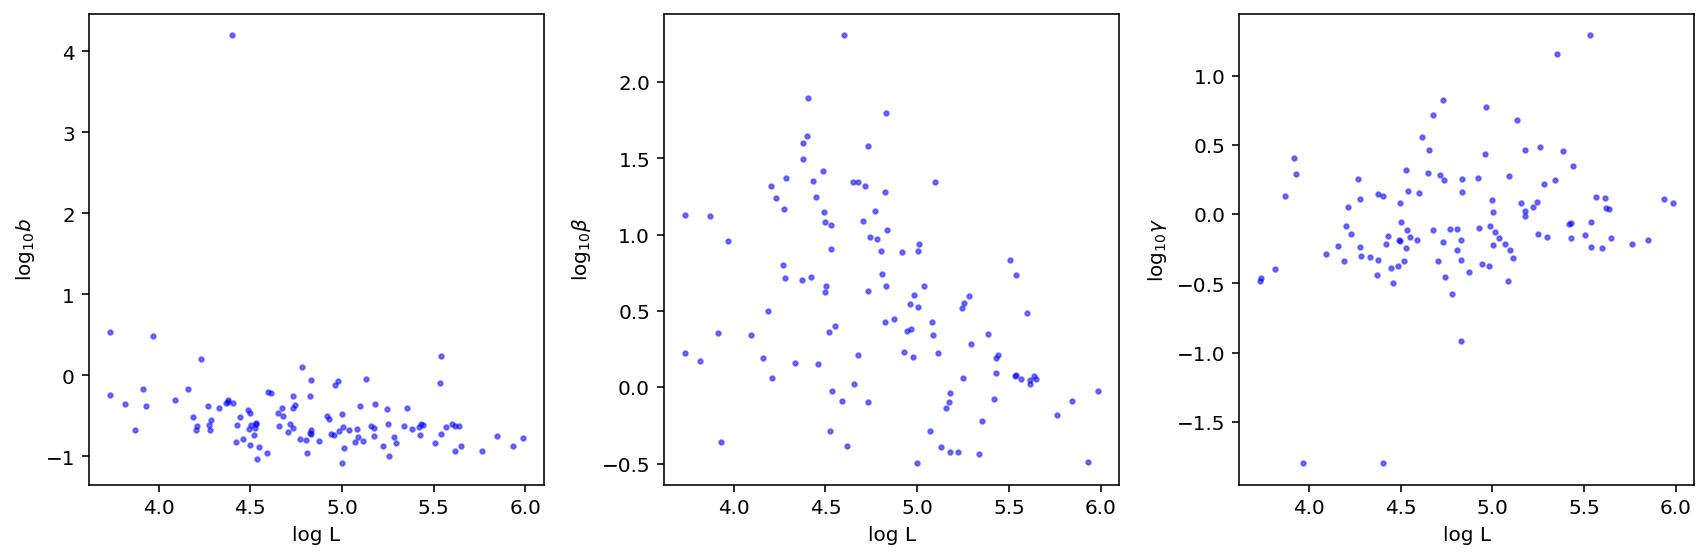

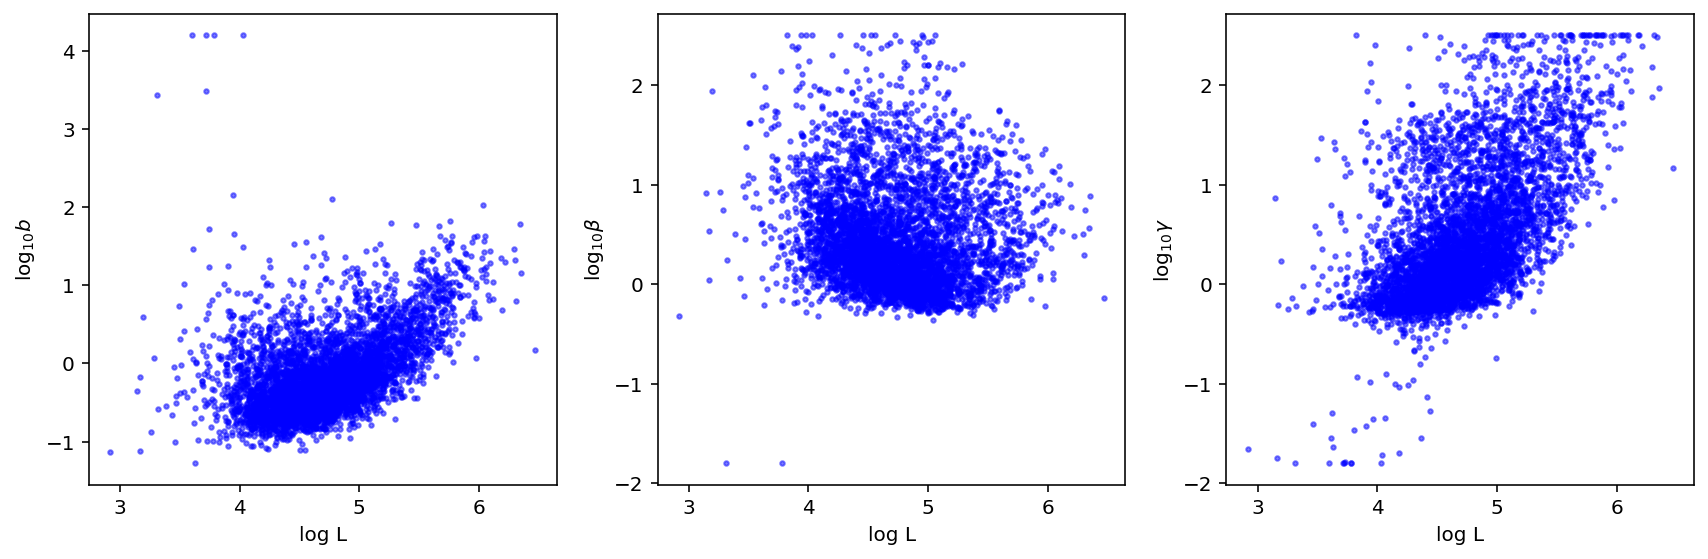

In [23]:
for i in range(0,len(results)):
    print(out_names[i])
    plot_param_L_dep(results[i],plot_errorbars=False,nosamp=True,chisq_correct=False)  #Should see length dep

In [ ]:
chisq_gen(results[0],EPS=1e-20)

pbmcs_10x
crisprsgNegCtrl02093a_sgNegCtrl3b
adata_24754_6
desai_dmso
clytia_SWall
clytiaNeural
clytiaNematocyte
nsc45
neurons_10k


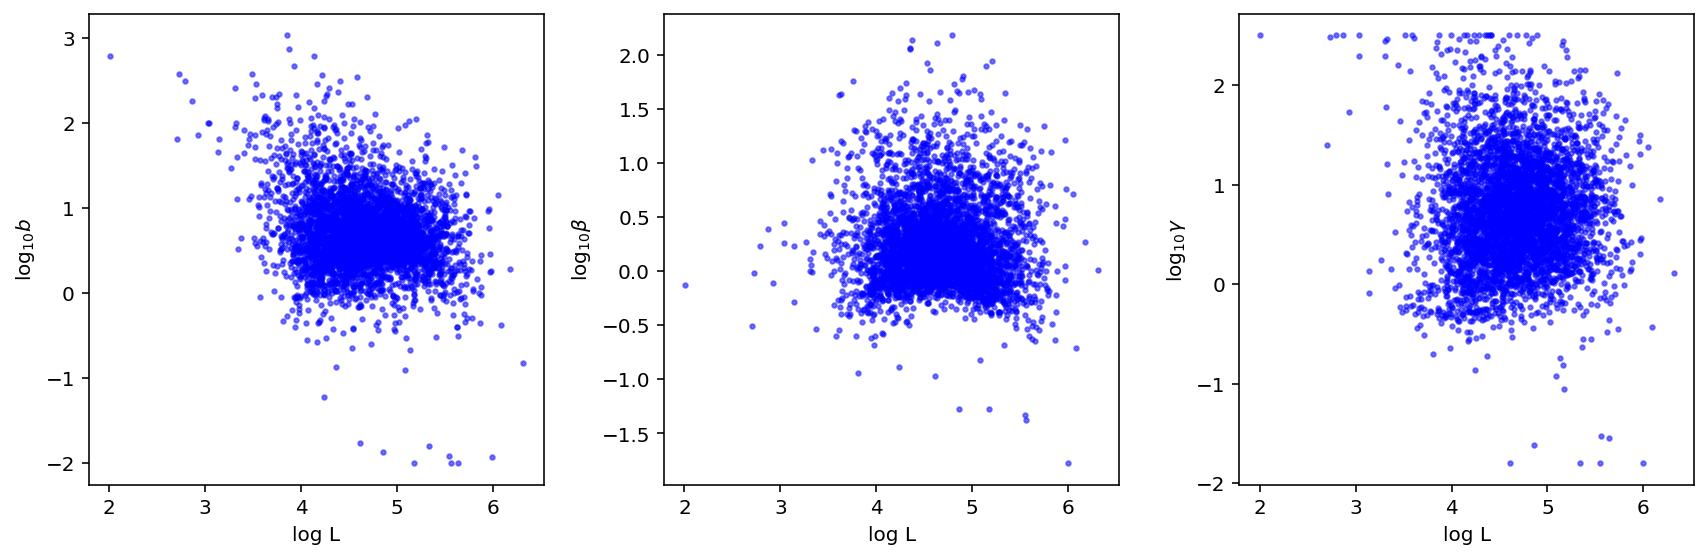

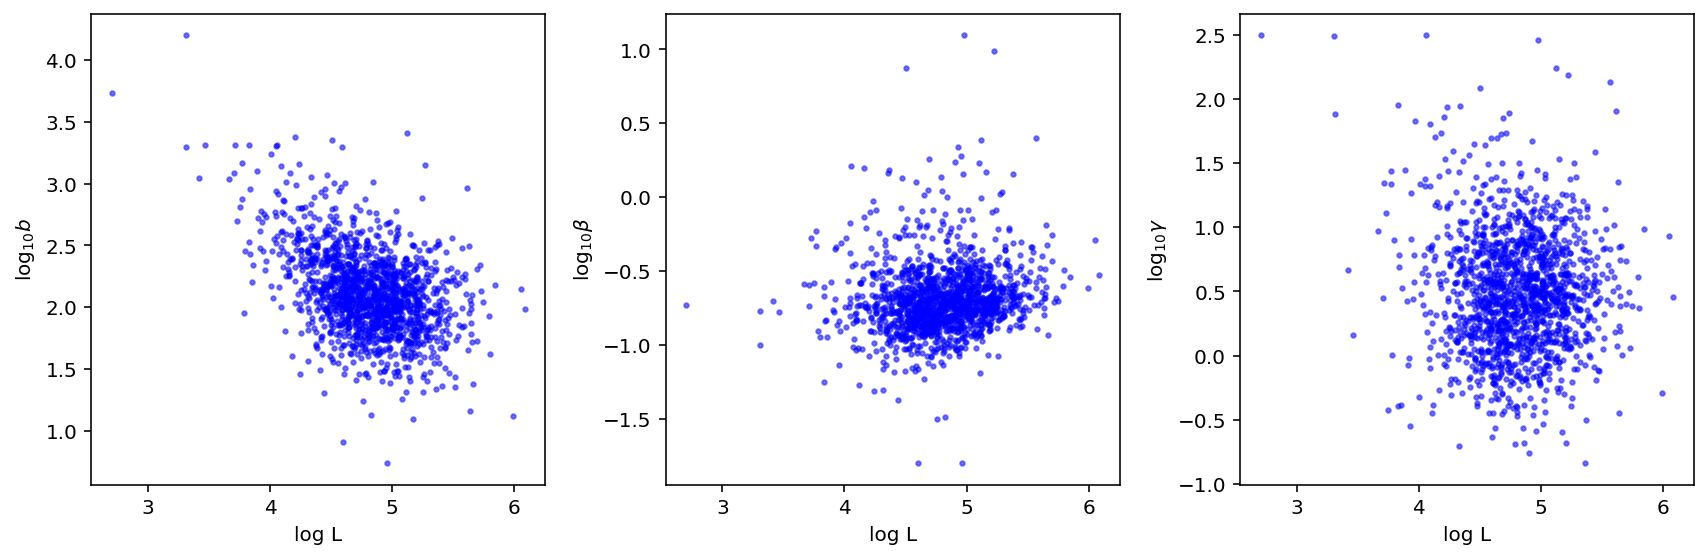

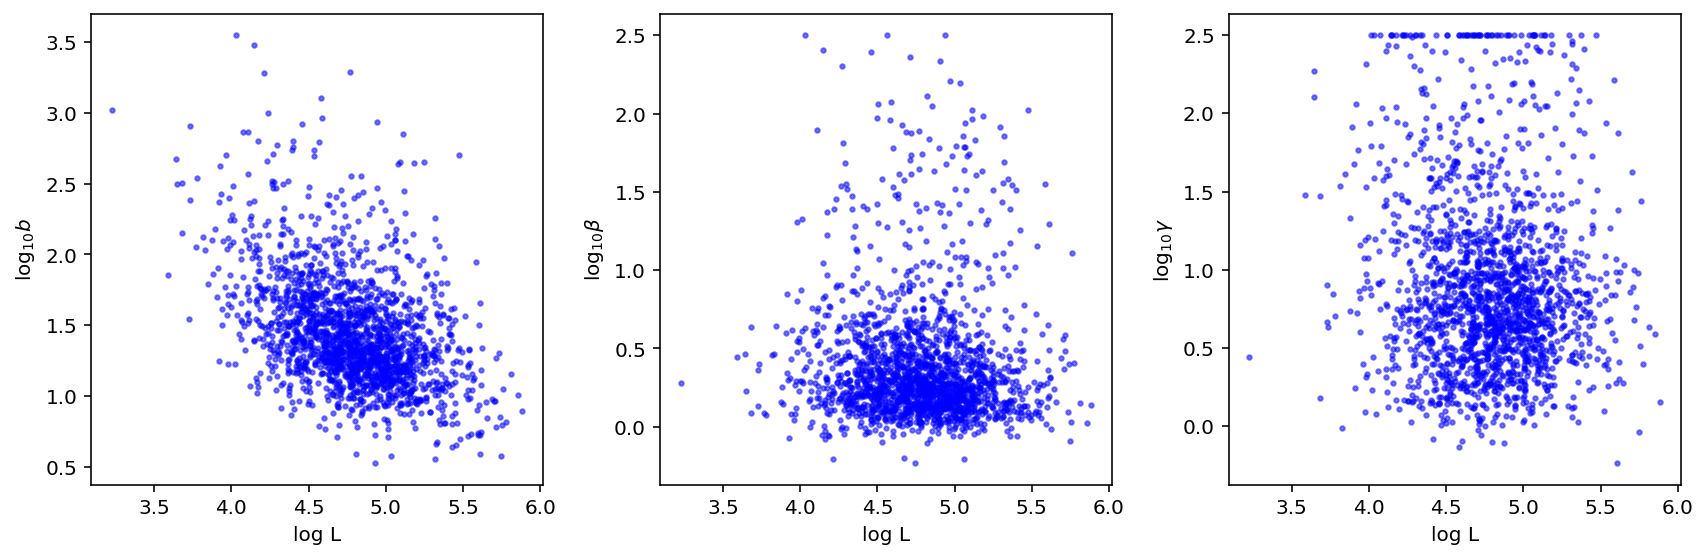

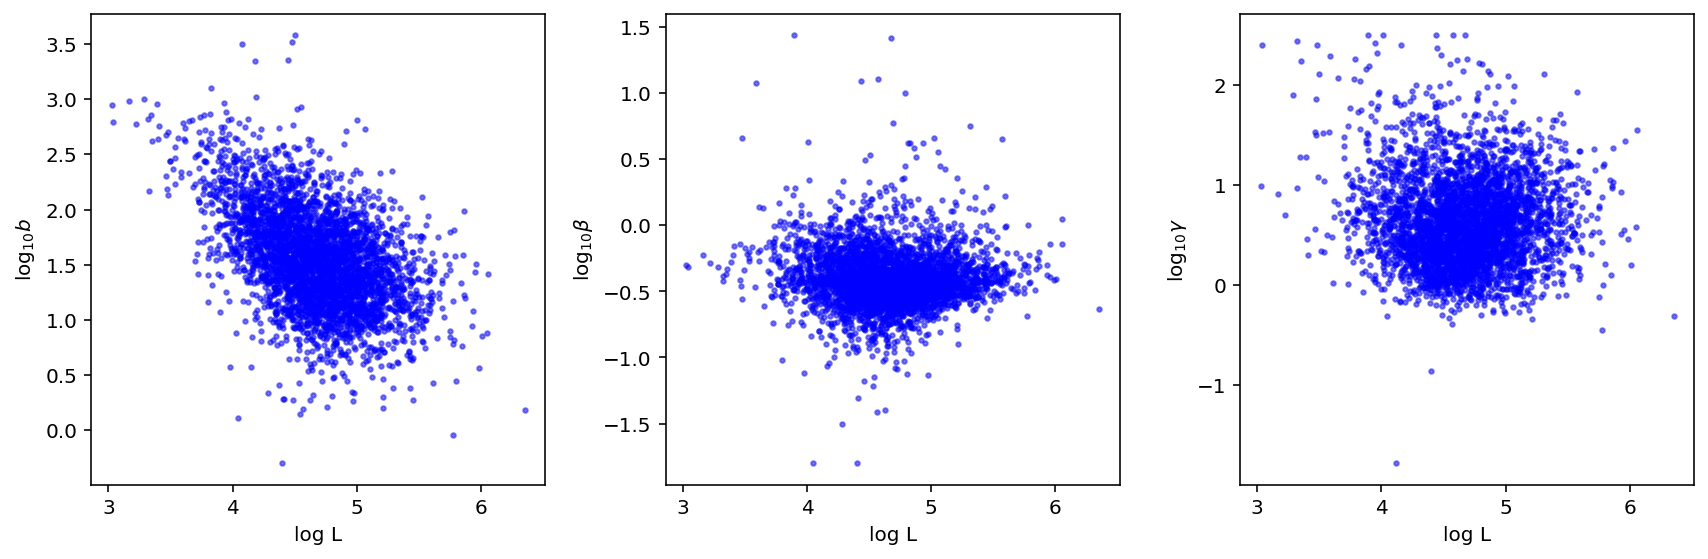

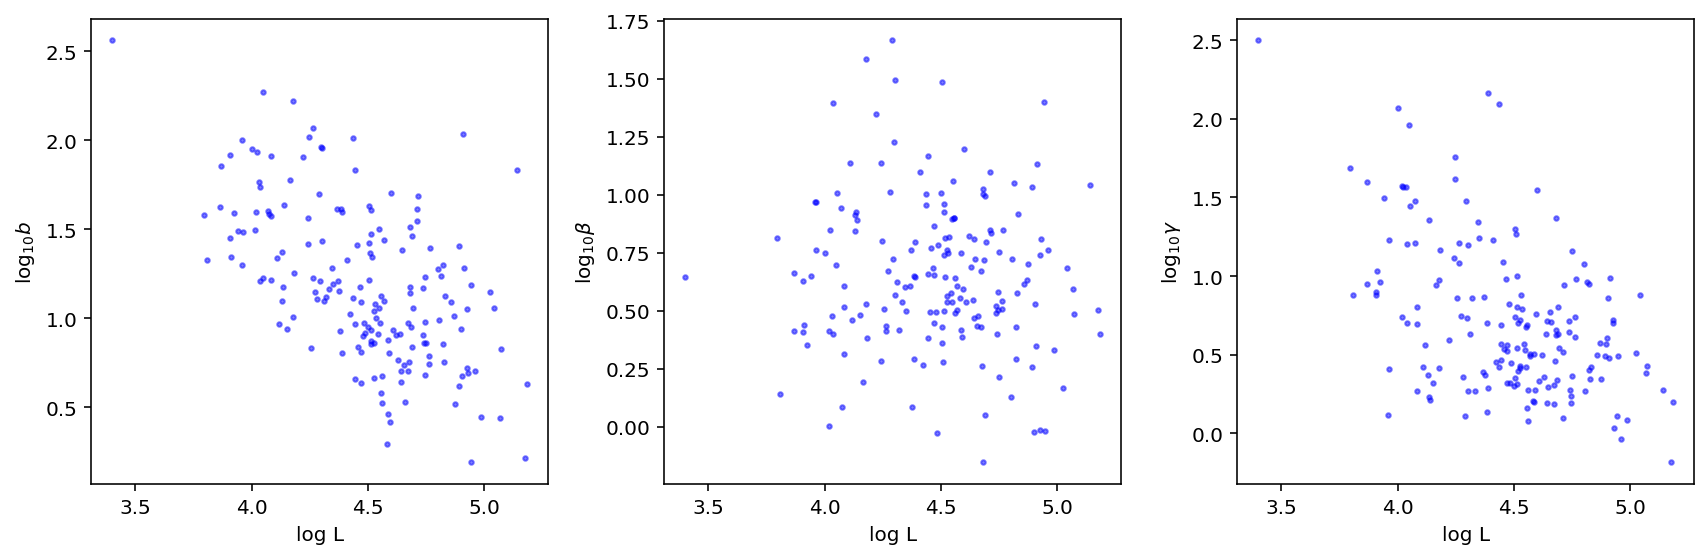

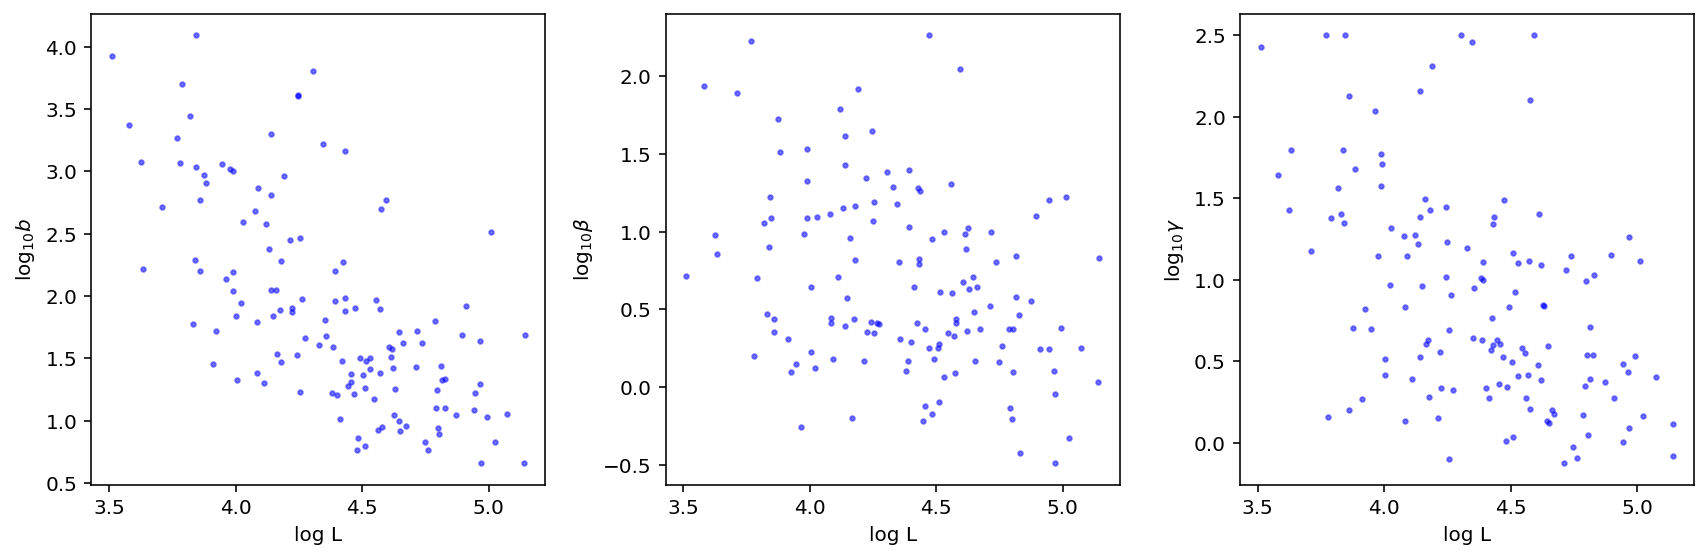

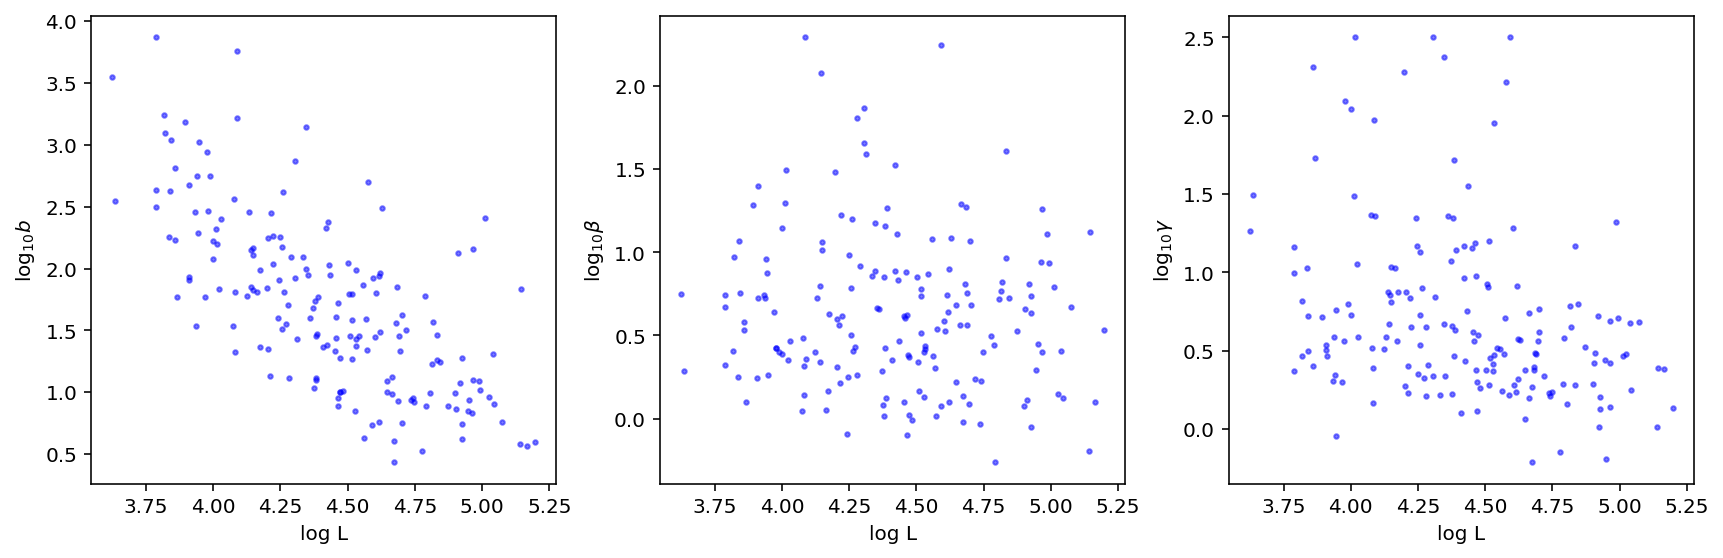

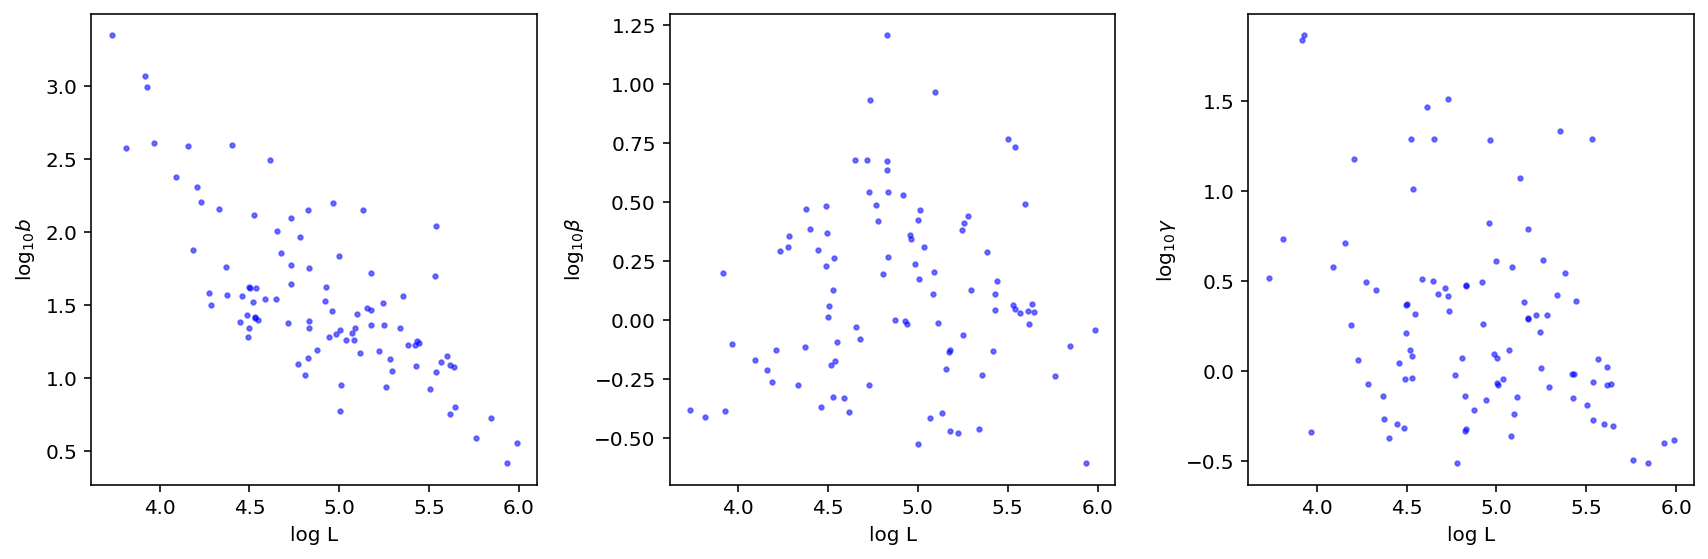

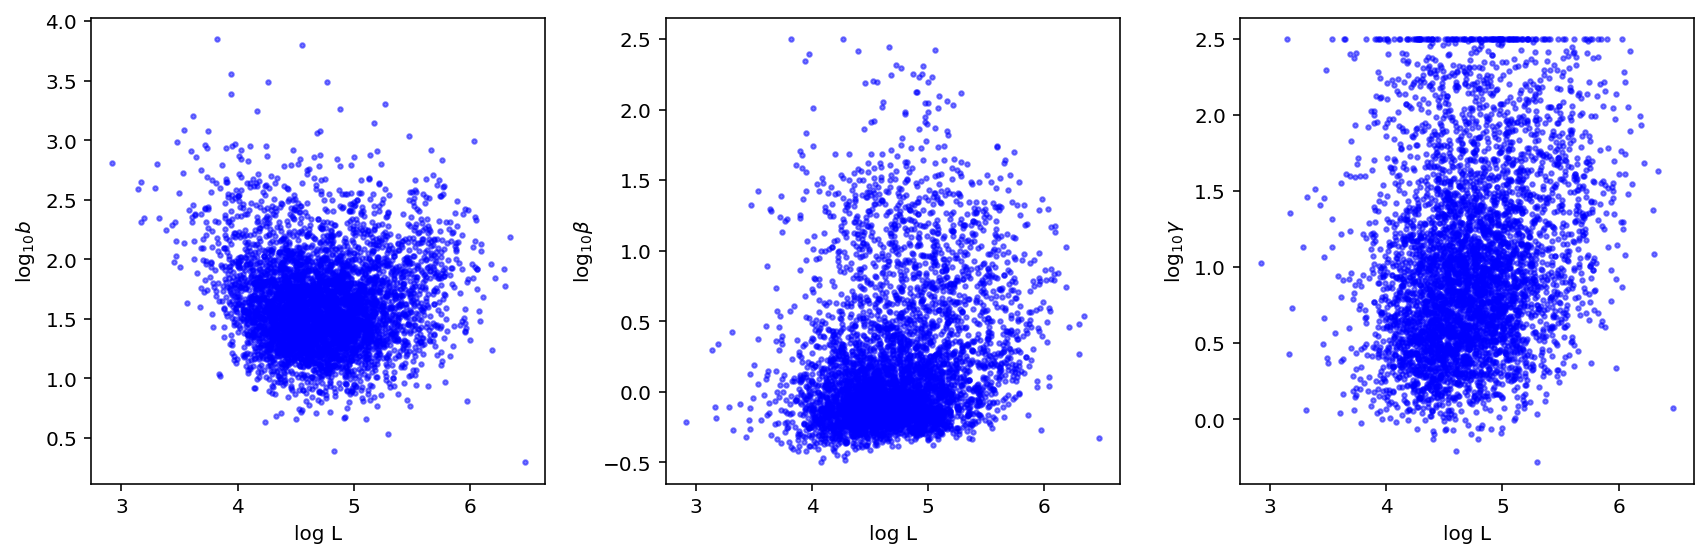

In [24]:
for i in range(0,len(results)):
    print(out_names[i])
    plot_param_L_dep(results[i],plot_errorbars=False)  #Many not showing length dep

#### Check nematocyte genes

In [19]:
#Check nematocyte gene names
remain = np.array(results[0].gene_names)[~results[0].gene_rej & ~check_at_bounds(results[0],results[0].best_phys_params)]


In [20]:
#Add later timepoint genes
cnidoGenes = ['XLOC_044122','XLOC_008048','XLOC_030068','XLOC_011074','XLOC_041365','XLOC_041836','XLOC_011949','XLOC_015554',
              'XLOC_039385','XLOC_045474',
              'XLOC_004102','XLOC_043404','XLOC_005363','XLOC_039341',
              'XLOC_017845','XLOC_018627','XLOC_011922','XLOC_003773','XLOC_011100',
              'XLOC_019170']

[i for i in cnidoGenes if i in remain]

['XLOC_041365', 'XLOC_045474']

In [22]:
[i for i in cnidoGenes if i in results[0].gene_names]

['XLOC_041365', 'XLOC_045474']

In [24]:
annos = pd.read_csv('/home/tchari/clytiaRef/tc_220309_genome_polyA_cum_clytia', sep=' ',header=None,usecols=[0])
annos.head()

,0
0,XLOC_000078
1,XLOC_000001
2,XLOC_000002
3,XLOC_000150
4,XLOC_000151


In [25]:
len([i for i in cnidoGenes if i in list(annos[0])])/len(cnidoGenes) #all nematocyte genes in reference

1.0

In [34]:
import loompy
nemato = loompy.connect('/home/tchari/counts/clytia_stim/loom/clytiaNematocyte.loom')
nemato.ra.keys()

['Gene', 'var_names']

In [35]:
gene_names = nemato.ra['Gene']

In [36]:
S = nemato.layers['spliced'].sparse()

In [37]:
S.shape

(45872, 1256)

In [38]:
U = nemato.layers['unspliced'].sparse()

In [39]:
nemato.close()

In [40]:
S_max = np.amax(S,1)
U_max = np.amax(U,1)
S_mean = np.mean(S,1)
U_mean = np.mean(U,1)        

In [41]:
#filt='0.01, 0.01, 350, 350, 3, 3'
for i in cnidoGenes:
    find = gene_names == i
    
    print(np.array(U_mean)[find],np.array(S_mean)[find],
          np.array(S_max.todense())[find], np.array(U_max.todense())[find] )

[[0.00716561]] [[18.97531847]] [[290.]] [[1.]]
[[0.01512739]] [[4.21815287]] [[65.]] [[2.]]
[[0.00955414]] [[2.86783439]] [[37.]] [[1.]]
[[0.00159236]] [[5.66799363]] [[79.]] [[1.]]
[[0.10509554]] [[15.97372611]] [[151.]] [[2.]]
[[0.02229299]] [[7.60429936]] [[79.]] [[2.]]
[[0.00159236]] [[0.19187898]] [[5.]] [[1.]]
[[0.01990446]] [[0.77547771]] [[12.]] [[2.]]
[[0.00318471]] [[3.48646497]] [[67.]] [[1.]]
[[1.5589172]] [[2.80652866]] [[37.]] [[25.]]
[[0.00875796]] [[0.47929936]] [[21.]] [[1.]]
[[0.]] [[0.0111465]] [[2.]] [[0.]]
[[0.00159236]] [[0.15286624]] [[5.]] [[1.]]
[[0.00079618]] [[0.05493631]] [[4.]] [[1.]]
[[0.]] [[0.00079618]] [[1.]] [[0.]]
[[0.00557325]] [[0.23805732]] [[4.]] [[1.]]
[[0.00398089]] [[0.1727707]] [[5.]] [[1.]]
[[0.00398089]] [[0.05652866]] [[2.]] [[1.]]
[[0.00079618]] [[0.1616242]] [[6.]] [[1.]]
[[0.00238854]] [[0.1656051]] [[4.]] [[1.]]


In [136]:
cnidoGenes[9] #Only cnido plot gene that passes cutoff (3+ unspliced counts)

'XLOC_045474'

In [139]:
np.array(cnidoGenes)[[1,4,5,7,9]]

array(['XLOC_008048', 'XLOC_041365', 'XLOC_041836', 'XLOC_015554',
       'XLOC_045474'], dtype='<U11')

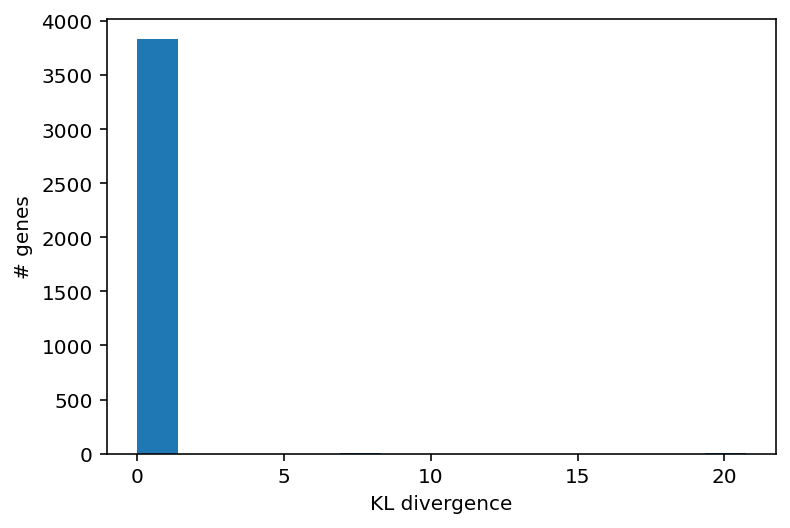

In [48]:
#Look at performance of combo control
plot_KL(results[3])
#chisq_best_param_correction(results[4],overwrite=True,EPS=1e-20)

In [35]:
# #Get all non-rejected genes across all samples

# filt_genes = set(list(np.where(~results[0].gene_rej)[0]))
# for i in range(1,len(results)):
#     filt_genes = filt_genes.intersection(set(list(np.where(~results[i].gene_rej)[0]))) #Get new filter gene list

In [36]:

# filt_genes = list(filt_genes)
# len(filt_genes)

1142